<a href="https://colab.research.google.com/github/clacri/CASP14_MR_evaluation/blob/main/CASP_ReLLG_Exploration_Results_Prediction_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First setting up steps
#!pip install brokenaxes

# Python imports
import os
import pandas as pd
from IPython.display import display
import numpy
from operator import itemgetter

# Google drive mounting to get the data
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

# Plotting related
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])

Mounted at /content/drive


In [ ]:
# Second setting up step
path_claudia_prediction_tables = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/Prediction_reLLG_tables/"
# There is also information about which structures do have x-ray data
path_data = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/targets_xray.csv"
# And which groups identifiers correspond with wich names
path_groups = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/groups.csv"
output_dir = '/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/'

# Including also the information from Marcus and Joana's runs
path_llgs_prediction = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/df_mr_for_Randy.csv"

# More info about experimental data
path_csv_all_methods = "/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/target_experiment_types.csv"

In [ ]:
# Read in extra information

# About availability of x-ray data
df_data_xray = pd.read_csv(path_data, header=None)
df_data_xray.columns = ['Target']
list_xray_full = df_data_xray['Target'].tolist()
list_xray = [ele[1:] for ele in list_xray_full]
#print('\nTargets with x-ray data',list_xray)
#display(df_data_xray)

# About availability of cryo-em data
# This info comes from the website https://predictioncenter.org/casp14/cryoem_results.cgi
# On that link there are multiple domains from the targets but I guess the target itself in full has the associated data
# Looking on the site, I found the cryoem targets are: H1036, T1026, T1036, T1092, T1093, T1094, T1095, T1096, T1099
# H1036 is a multimeric target but is the same structure that T1036, a cryoem structure with pdb id 6vn1
list_cryoem = ['1026', '1036', '1092', '1093', '1094', '1095', '1096', '1099']
#print('\nTargets with CryoEM data',list_cryoem) 

# About the names of the groups
df_groups_key = pd.read_csv(path_groups,delimiter=';',dtype=str)
df_groups_key.columns = ['Name_Group','Group','Type']
df_groups_key['Group'] = df_groups_key['Group'].astype(str)
del df_groups_key['Type']
#display(df_groups_key)
groupnames_dict = dict(zip(df_groups_key['Group'], df_groups_key['Name_Group']))
#print("\nGroup names and numbers correspondence",groupnames_dict)


# Master csv with all info now
df_global_methods= pd.read_csv(path_csv_all_methods,delimiter=',',dtype=str, header=None)
df_global_methods.columns = ['Target_Evaluation','Experimental_Method']
#display(df_global_methods)

# Also list with all the targets to be able to use it to penalise groups who did not submit a target
list_target_evaluation = df_global_methods['Target_Evaluation'].tolist()
#print("List target evaluation",list_target_evaluation)

#display(df_groups_key)

In [ ]:
# Function definitions (to avoid whenever possible code duplication)

def include_penalization(dati,treatment,list_target_evaluation):
  print("BEFORE ADDING PENALIZATION",len(dati))
  list_dataframes_to_concat = []
  by_groups = dati.groupby(['Name_Group'])
  for group in by_groups:
    #print("\n\nChecking targets evaluated for group  ",group[0])
    targets_evaluated_by_group = group[1]['Target_Evaluation'].unique() 
    #print("Targets evaluated by this group are ",len(targets_evaluated_by_group))
    #print(targets_evaluated_by_group)
    diff = set(list_target_evaluation)-set(targets_evaluated_by_group)
    if len(diff) > 0:
      #print("Diff is ",diff)
      #print("This group did not predict the targets:")
      # we then need to add a row per each target not evaluated
      new_df = group[1].copy(deep=True)
      for not_evaluated in diff:
        #print(not_evaluated)
        new_df = new_df.append({'Model': "dummy"+str(not_evaluated),"reLLG_"+treatment:0, "status_"+treatment:0,"Target_Evaluation":not_evaluated,"Target":not_evaluated[:5],"Self_rank":1,"Group":"None","reLLG_"+treatment+"_zscore":-2, "Name_Group":group[0],"Has_Xray_Data":False, "Has_EM_Data":False,"Experimental_Method":"None"},ignore_index=True)
        #print("AFTER")
      #display(new_df)
      list_dataframes_to_concat.append(new_df)
      #break
    else: # we will concatenate as it is
      same_df = group[1].copy(deep=True)
      #display(same_df)
      list_dataframes_to_concat.append(same_df)
      #break
  concatenated = pd.concat(list_dataframes_to_concat)
  print("AFTER ADDING PENALIZATION",len(concatenated))
  #display(concatenated)
  return concatenated

def compute_ranking_and_plot(dataf,column_name,stat,filter_negative=False,color="cornflowerblue"):
  if stat=='mean':
    rank = dataf.groupby(['Name_Group'])[column_name].mean()
  elif stat=='sum':
    rank = dataf.groupby(['Name_Group'])[column_name].sum()
  elif stat=='median':
    rank = dataf.groupby(['Name_Group'])[column_name].median()
  # We then sort the rank
  rank.sort_values(inplace=True,ascending=False)
  if filter_negative:
    rank = rank[rank>=0]
  # Now do the plot
  plot = rank.plot.bar(width=0.8, color=color)
  #print("Ranking according to: "+stat+' '+column_name+" for each group")
  #print(rank)
  #plot.set_title(stat+' '+column_name+' for each group')
  plot.set_ylabel(stat+' '+column_name)
  #plot.figure.savefig("prediction_ranking_"+stat+'_'+column_name+".png",bbox_inches = "tight")
  #files.download("prediction_ranking_"+stat+'_'+column_name+".png") # This will download it
  return rank, plot


def get_list_color_ref(indices_rank,skip_fac=1):
  list_colour=[]
  for groupi in indices_rank.index:
    if groupi== '---STARTING-MODEL---':
      list_colour.append('C0')
    else:
      list_colour.append('C'+str(skip_fac))
  return list_colour

def merge_group_and_experimental_info(global_dataframe,list_xray, list_em, df_global_methods, df_groups_key):
  # Include the name of the group
  global_dataframe_merged = pd.merge(global_dataframe,df_groups_key,on="Group")
  # Also include info about x-ray experimental data
  global_dataframe_merged['Has_Xray_Data'] = global_dataframe_merged['Target'].isin(list_xray)
  # And about cryoEM
  global_dataframe_merged['Has_EM_Data'] = global_dataframe_merged['Target'].isin(list_em)
  # Finally add column about the experimental method
  global_dataframe_final = pd.merge(global_dataframe_merged,df_global_methods,on='Target_Evaluation')
  #global_dataframe_merged['Experimental_Method'] = numpy.where(global_dataframe_merged['Has_Xray_Data']==True, 'xray','undefined')
  #global_dataframe_merged.loc[global_dataframe_merged.Has_EM_Data == True, "Experimental_Method"] = "em"
  return global_dataframe_final

def read_single_target_dataframe_and_prepare(path_table,treatment,metric,remove_not_considered_metric=True):
  df = pd.read_csv(path_table)
  # Prepare dataframe for analysis
  # Remove white spaces in titles
  df.rename(columns=str.strip, inplace=True)
  # Remove the .pdb extension
  df['Model'] = df['Model'].str.replace(r'.pdb', '')
  df['Model'] = df['Model'].str.strip()
  for column in list(df.columns):
    if column=="Model":
      continue
    # Drop the columns we are not interested in looking this time unless set to be kept
    if remove_not_considered_metric:
      if (not column.endswith(treatment) or not column.startswith(metric)):
        if not column == 'status_'+treatment:
            del df[column]
  #display(df)
  # Include a column with the name of the group
  # Include a column with the name of the target
  # NOTE: I am sure there are better ways to do this. Also I will need to adapt to the different naming issues in Casp
  new = df["Model"].str.split("TS", n = 1, expand = True)
  #print("SHERLOCK new[0]",new[0]) # this is target name, we will have to combine with domain
  new_two = new[1].str.split("-",n=0,expand=True)
  df["Target_Evaluation"] = new[0]+'-'+new_two[1]
  df["Target"] = df["Target_Evaluation"].str[1:5]
  new = df["Model"].str.split("_", n = 1, expand = True)
  new_two = new[1].str.split("-",n=0,expand=True)
  df['Self_rank'] = new_two[0].str.strip()
  new_group = new[0].str.split("TS",n = 1, expand = True)
  df["Group"]= new_group[1]
  return df.copy()
  
def process_target_dataframe(df, column_name,only_first_model=True):
    # If the option only_first_model has been set I need to remove everything which does not have as the self-rank 1
    if only_first_model:
        df_filt = df.loc[df['Self_rank']=='1']
        df = df_filt.copy(deep=True)
        #display(df)
    # First do it for the as_rmsd option, compute mean and sd
    mean_val = df[column_name].mean() 
    #print("Mean value for ",column_name, " is ", mean_val)
    std_val = df[column_name].std()
    #print("Standard deviation value for ", column_name," is ", std_val)
    # Zscore 
    # The formula for calculating a z-score is is z = (x-μ)/σ
    # where x is the raw score, μ is the population mean, and σ is the population standard deviation. 
    # For the zscore we use the full one (includes group 999 but it was not used for mean and std)
    df[column_name+'_zscore'] = (df[column_name] - mean_val)/std_val
    # Remove all models with a value of this zscore worse than -2 
    size_before = len(df)
    df_filt_minus2 = df[df[column_name+'_zscore'] > -2] 
    size_after = len(df_filt_minus2)
    #print("\n SHERLOCK before")
    #display(df)
    if size_after < size_before:
      # Then I need to do a second round of computation with the filtered dataset
      # Now we will use the filtered one to recompute the mean, std, and of course zscore
      mean_val_filt = df_filt_minus2[column_name].mean() 
      #print("Mean value for ",column_name, " is ", mean_val)
      std_val_filt = df_filt_minus2[column_name].std()
      del df[column_name+'_zscore'] # we will remove it and regenerate it again after the filtering
      df[column_name+'_zscore'] = (df[column_name] - mean_val_filt)/std_val_filt
      #print("\n SHERLOCK after")
      #display(df)
    return df.copy(), mean_val, std_val

def process_all_targets(path_tables,treatment,metric,error_check=False,only_first_model=True):
  # We will need a larger dataframe that will be constructed by adding the processed ones for each target
  # so we will save the individual ones in a list
  list_dataframes = []
  # Now iterate over all the csv tables (each one is a target)
  for fichi in os.listdir(path_tables):
     if fichi.endswith('.csv'):
        fullpathfichi = os.path.join(path_tables,fichi)
        # Read and process csv
        df_target = read_single_target_dataframe_and_prepare(fullpathfichi,treatment=treatment,metric=metric)
        # Now compute first round of zscore, using mean and std
        keyword_metric = metric+'_'+treatment
        df_target_with_zscores_first, mean_target, std_target = process_target_dataframe(df_target,keyword_metric,only_first_model)
        list_dataframes.append(df_target_with_zscores_first)
        if error_check:
          print("\n\n Processing table ",fichi)
          try:
            display(df_target['status_'+treatment].value_counts())
            #print("Errors about pdb formatting and extension compared to target found:  ")
            #display(df_target.loc[df_target['status_'+treatment] == -3])
            #print("Errors about random coil in tng found :  ")
            #display(df_target.loc[df_target['status_'+treatment] == -2])
            #print("Errors about too large model in tng found :  ")
            #display(df_target.loc[df_target['status_'+treatment] == -1])
          except:
            pass

  # Concat will join them by their rows, and produce a single dataframe containing the results for all targets
  df_all_targets = pd.concat(list_dataframes,axis=0,ignore_index=True)
  return df_all_targets

In [ ]:
# Now read and process all of our targets with the as_rmsd_treatment
df_all_targets_as_rmsd = process_all_targets(path_claudia_prediction_tables,treatment='as_rmsd',metric='reLLG',error_check=False,only_first_model=True)
# Include group name and experimental information
df_all_as_rmsd = merge_group_and_experimental_info(df_all_targets_as_rmsd,list_xray,list_cryoem,df_global_methods,df_groups_key)
# This dataframe contains only the models 1 processed and their zscores
display(df_all_as_rmsd)

,Model,reLLG_as_rmsd,status_as_rmsd,Target_Evaluation,Target,Self_rank,Group,reLLG_as_rmsd_zscore,Name_Group,Has_Xray_Data,Has_EM_Data,Experimental_Method
0,T1035TS003_1-D1,1.587568e-02,0,T1035-D1,1035,1,003,0.151671,SHORTLE,True,False,X-ray
1,T1035TS005_1-D1,7.160915e-05,0,T1035-D1,1035,1,005,-0.420403,Seder2020,True,False,X-ray
2,T1035TS009_1-D1,4.862775e-02,0,T1035-D1,1035,1,009,1.337229,tFold_human,True,False,X-ray
3,T1035TS013_1-D1,2.478478e-04,0,T1035-D1,1035,1,013,-0.414024,FEIG-S,True,False,X-ray
4,T1035TS014_1-D1,6.293890e-05,0,T1035-D1,1035,1,014,-0.420717,xianmingpan,True,False,X-ray
...,...,...,...,...,...,...,...,...,...,...,...,...
10711,T1036s1TS468_1-D1,8.411862e-06,0,T1036s1-D1,1036,1,468,-0.662648,FALCON-geom,False,True,Cryo-EM
10712,T1036s1TS487_1-D1,6.389361e-02,0,T1036s1-D1,1036,1,487,3.028000,RaptorX,False,True,Cryo-EM
10713,T1036s1TS033_1-D1,1.487417e-07,0,T1036s1-D1,1036,1,033,-0.663125,ishidalab,False,True,Cryo-EM
10714,T1036s1TS211_1-D1,7.851269e-03,0,T1036s1-D1,1036,1,211,-0.209566,MESHI_server,False,True,Cryo-EM


In [ ]:
#Just checking the different plotting styles
#for style in plt.style.available:
#    print(" This style is called ",style)
#    plt.style.use(style)
    # Note this histogram has all single instances of pairs of targets/models for all groups
#    histogram_all_as_rmsd = df_all_as_rmsd.plot(y='reLLG_as_rmsd_zscore',kind='hist',title='reLLG_as_rmsd_zscore_all_targets_and_models_prediction',bins=24)
 #   histogram_all_as_rmsd.figure.savefig("reLLG_as_rmsd_zscore_all_targets_and_models_prediction.png")
 #   plt.show()
    # This will download it
    #files.download("reLLG_as_rmsd_zscore_all_targets_and_models_prediction.png") 

In [ ]:
# Now read and process all of our targets with the constant bfactor treatment
# This one can be helpful to compare the raw coordinate correctness with the estimation of the error
df_all_targets_constantb = process_all_targets(path_claudia_prediction_tables,treatment='bfactor_constant',metric='reLLG',error_check=False,only_first_model=True)
# Include group name and experimental information
df_all_bfact_constant = merge_group_and_experimental_info(df_all_targets_constantb,list_xray,list_cryoem,df_global_methods,df_groups_key)
# This contains only the model 1
display(df_all_bfact_constant)

,Model,reLLG_bfactor_constant,status_bfactor_constant,Target_Evaluation,Target,Self_rank,Group,reLLG_bfactor_constant_zscore,Name_Group,Has_Xray_Data,Has_EM_Data,Experimental_Method
0,T1035TS003_1-D1,0.016306,0,T1035-D1,1035,1,003,0.241752,SHORTLE,True,False,X-ray
1,T1035TS005_1-D1,0.011741,0,T1035-D1,1035,1,005,0.047657,Seder2020,True,False,X-ray
2,T1035TS009_1-D1,0.048628,0,T1035-D1,1035,1,009,1.616227,tFold_human,True,False,X-ray
3,T1035TS013_1-D1,0.000150,0,T1035-D1,1035,1,013,-0.445271,FEIG-S,True,False,X-ray
4,T1035TS014_1-D1,0.000059,0,T1035-D1,1035,1,014,-0.449125,xianmingpan,True,False,X-ray
...,...,...,...,...,...,...,...,...,...,...,...,...
10711,T1036s1TS468_1-D1,0.000008,0,T1036s1-D1,1036,1,468,-0.702721,FALCON-geom,False,True,Cryo-EM
10712,T1036s1TS487_1-D1,0.065731,0,T1036s1-D1,1036,1,487,3.423554,RaptorX,False,True,Cryo-EM
10713,T1036s1TS033_1-D1,0.013832,0,T1036s1-D1,1036,1,033,0.165195,ishidalab,False,True,Cryo-EM
10714,T1036s1TS211_1-D1,0.006497,0,T1036s1-D1,1036,1,211,-0.295327,MESHI_server,False,True,Cryo-EM


In [ ]:
# We check the number of targets predicted by the groups to see which ones we will consider for the ranking
total_targets = len(df_all_as_rmsd['Target_Evaluation'].unique())
print("\nNumber of unique targets is ",total_targets)
total_groups = len(df_all_as_rmsd['Name_Group'].unique())
print("\nNumber of unique groups is ",total_groups)


rank_models_evaluated = df_all_as_rmsd.groupby(['Name_Group'])['Model'].count() # there is already only one model per target
rank_models_evaluated.sort_values(inplace=True,ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # This trick is to avoid the output data series to be truncated
    print(rank_models_evaluated)
#rank_models_evaluated.plot.bar(color=list_colour,figsize=(40,10))



Number of unique targets is  96

Number of unique groups is  146
Name_Group
MULTICOM-DEEP          96
Zhang-TBM              96
Zhang-CEthreader       96
Yang_TBM               96
Yang_FM                96
Yang-Server            96
FEIG-S                 96
FoldX                  96
IntFOLD6               96
TOWER                  96
Kiharalab_Z_Server     96
Seok-server            96
LAW                    96
MASS                   96
MUFOLD2                96
MULTICOM-CLUSTER       96
MULTICOM-CONSTRUCT     96
MULTICOM-DIST          96
MULTICOM-HYBRID        96
RaptorX                96
QUARK                  96
Zhang-Server           96
FALCON-DeepFolder      96
Zhang_Ab_Initio        96
3D-JIGSAW-SwarmLoop    96
BAKER-ROSETTASERVER    96
tFold                  96
BhageerathH-Plus       96
tFold-CaT              96
ACOMPMOD               96
tFold-IDT              96
CAO-SERVER             96
CATHER                 96
RBO-PSP-CP             95
AWSEM-Suite            95
MUFOLD       

In [ ]:
# Analysis of specific targets of interest to compare LLG values to the new metric, the reLLG
# First read the info about LLG from Marcus and Joana file
df_llg_data = pd.read_csv(path_llgs_prediction)
new = df_llg_data["Model"].str.split("TS", n = 1, expand = True)
#print("SHERLOCK new[0]",new[0]) # this is target name, we will have to combine with domain
new_two = new[1].str.split("-",n=0,expand=True)
df_llg_data["Target_Evaluation"] = new[0]+'-'+new_two[1]
df_llg_data["Target"] = df_llg_data["Target_Evaluation"].str[1:5]
#display(df_llg_data)
list_subset_targets_with_llg_data = df_llg_data["Target_Evaluation"].unique()
print("Unique values are ",df_llg_data["Target_Evaluation"].unique())
print("Unique values are ",len(df_llg_data["Target_Evaluation"].unique()))
print("Unique values are ",df_llg_data["Target"].unique())
print("Unique values are ",len(df_llg_data["Target"].unique()))


Unique values are  ['T1024-D1' 'T1024-D2' 'T1030-D1' 'T1030-D2' 'T1032-D1' 'T1034-D1'
 'T1038-D1' 'T1038-D2' 'T1046s1-D1' 'T1046s2-D1' 'T1049-D1' 'T1050-D1'
 'T1050-D2' 'T1050-D3' 'T1052-D1' 'T1052-D2' 'T1052-D3' 'T1053-D1'
 'T1053-D2' 'T1054-D1' 'T1056-D1' 'T1058-D1' 'T1058-D2' 'T1064-D1'
 'T1065s1-D1' 'T1065s2-D1' 'T1067-D1' 'T1070-D1' 'T1070-D2' 'T1070-D3'
 'T1070-D4' 'T1073-D1' 'T1074-D1' 'T1079-D1' 'T1080-D1' 'T1082-D1'
 'T1083-D1' 'T1084-D1' 'T1085-D1' 'T1085-D2' 'T1085-D3' 'T1086-D1'
 'T1086-D2' 'T1087-D1' 'T1089-D1' 'T1090-D1' 'T1091-D1' 'T1091-D2'
 'T1091-D3' 'T1091-D4' 'T1100-D1' 'T1100-D2' 'T1101-D1' 'T1101-D2']
Unique values are  54
Unique values are  ['1024' '1030' '1032' '1034' '1038' '1046' '1049' '1050' '1052' '1053'
 '1054' '1056' '1058' '1064' '1065' '1067' '1070' '1073' '1074' '1079'
 '1080' '1082' '1083' '1084' '1085' '1086' '1087' '1089' '1090' '1091'
 '1100' '1101']
Unique values are  32


In [ ]:
# Re-read the data to get all models for the next plots (we will use the b-factor constant treatment)
df_cons_all = process_all_targets(path_claudia_prediction_tables,treatment='bfactor_constant',metric='reLLG',error_check=False,only_first_model=False)
df_bcons= merge_group_and_experimental_info(df_cons_all,list_xray,list_cryoem,df_global_methods,df_groups_key)
# This one has all 5 models
display(df_bcons)

,Model,reLLG_bfactor_constant,status_bfactor_constant,Target_Evaluation,Target,Self_rank,Group,reLLG_bfactor_constant_zscore,Name_Group,Has_Xray_Data,Has_EM_Data,Experimental_Method
0,T1035TS003_1-D1,0.016306,0,T1035-D1,1035,1,003,0.295163,SHORTLE,True,False,X-ray
1,T1035TS005_1-D1,0.011741,0,T1035-D1,1035,1,005,0.095120,Seder2020,True,False,X-ray
2,T1035TS005_2-D1,0.012332,0,T1035-D1,1035,2,005,0.121019,Seder2020,True,False,X-ray
3,T1035TS005_3-D1,0.012663,0,T1035-D1,1035,3,005,0.135527,Seder2020,True,False,X-ray
4,T1035TS005_4-D1,0.012382,0,T1035-D1,1035,4,005,0.123180,Seder2020,True,False,X-ray
...,...,...,...,...,...,...,...,...,...,...,...,...
48821,T1036s1TS451_1-D1,0.016561,0,T1036s1-D1,1036,1,451,0.759461,Seok-assembly,False,True,Cryo-EM
48822,T1036s1TS451_2-D1,0.019396,0,T1036s1-D1,1036,2,451,1.009311,Seok-assembly,False,True,Cryo-EM
48823,T1036s1TS451_3-D1,0.015286,0,T1036s1-D1,1036,3,451,0.647116,Seok-assembly,False,True,Cryo-EM
48824,T1036s1TS451_4-D1,0.031484,0,T1036s1-D1,1036,4,451,2.074711,Seok-assembly,False,True,Cryo-EM


Text(0, 0.5, 'reLLG')

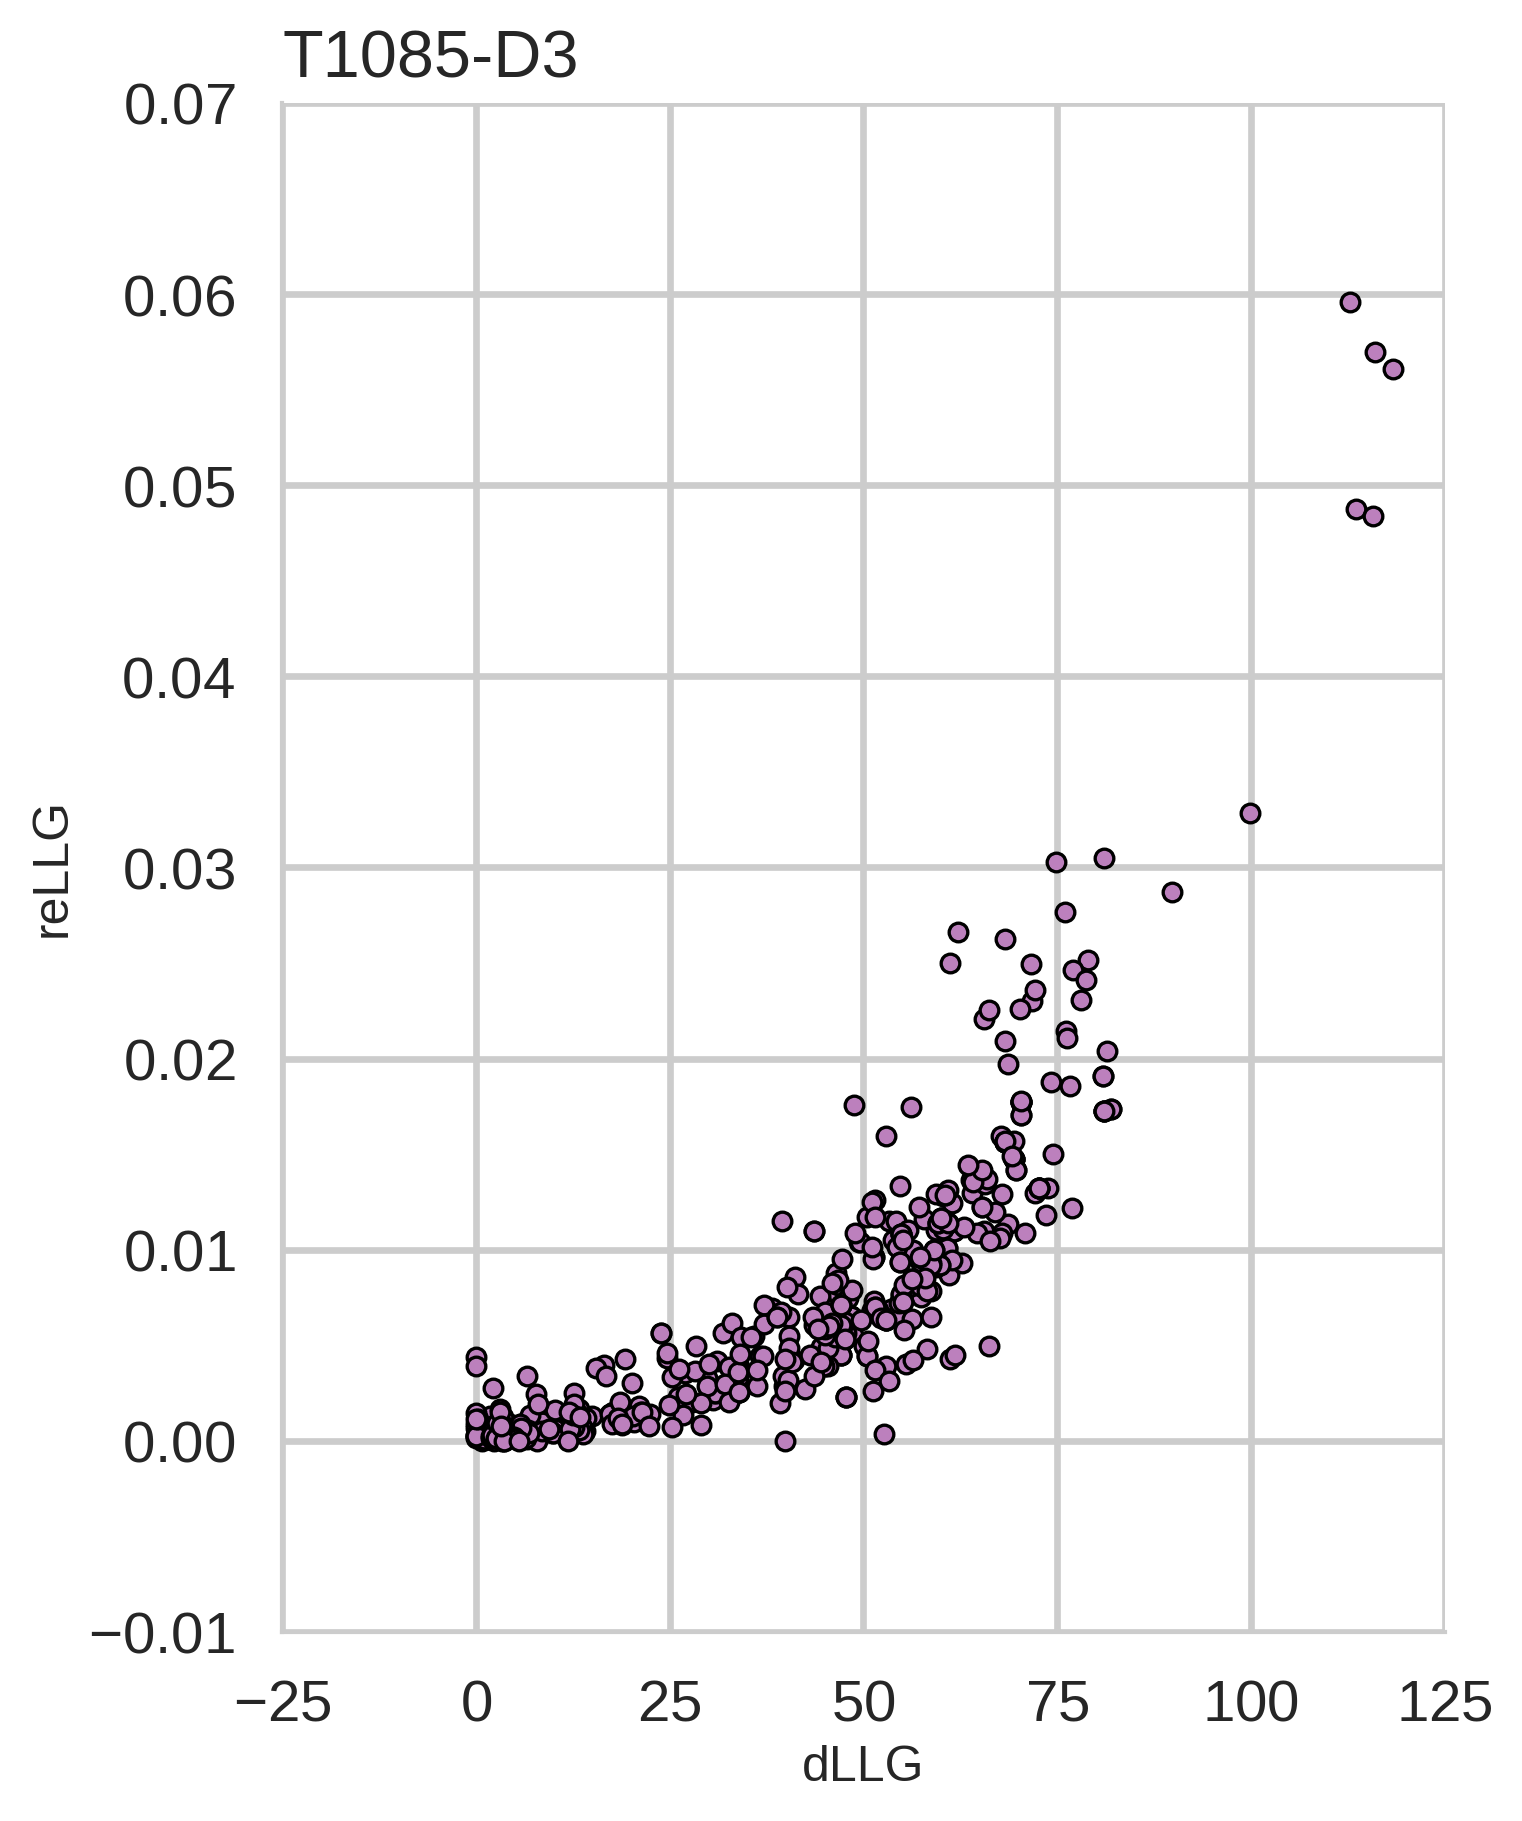

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])
# Analysis of specific targets of interest
#T1085-D3  TBM-hard and 1/10 of structure.
subset_llg_t1085 = df_llg_data.loc[df_llg_data['Model'].str.startswith('T1085') & df_llg_data['Model'].str.endswith('D3')]
#display(subset_llg_t1085)

# with column set to a constant bfactor
#########################################

# df_bcons
subset_bcons_t1085= df_bcons.loc[df_bcons['Model'].str.startswith('T1085') & df_bcons['Model'].str.endswith('D3')]
#display(subset_bcons_t1085)
#print("Size subset bcons",len(subset_bcons_t1085))
merge_for_scatter_bcons_t1085 = pd.merge(subset_llg_t1085,subset_bcons_t1085)
#display(merge_for_scatter_bcons_t1085)
#print("size of merge ",merge_for_scatter_bcons_t1085)
# columns of interest for this scatter will be LLG_const_B_deltaLLG and reLLG_bfactor_constant
plotted_bcons = merge_for_scatter_bcons_t1085.plot.scatter(x='LLG_const_B_deltaLLG',y='reLLG_bfactor_constant',figsize=(5,6.75),s=20,fontsize=14)
plotted_bcons.set_title("T1085-D3")
plotted_bcons.set_xlabel("dLLG")
plotted_bcons.set_ylabel("reLLG")

Text(0, 0.5, 'reLLG')

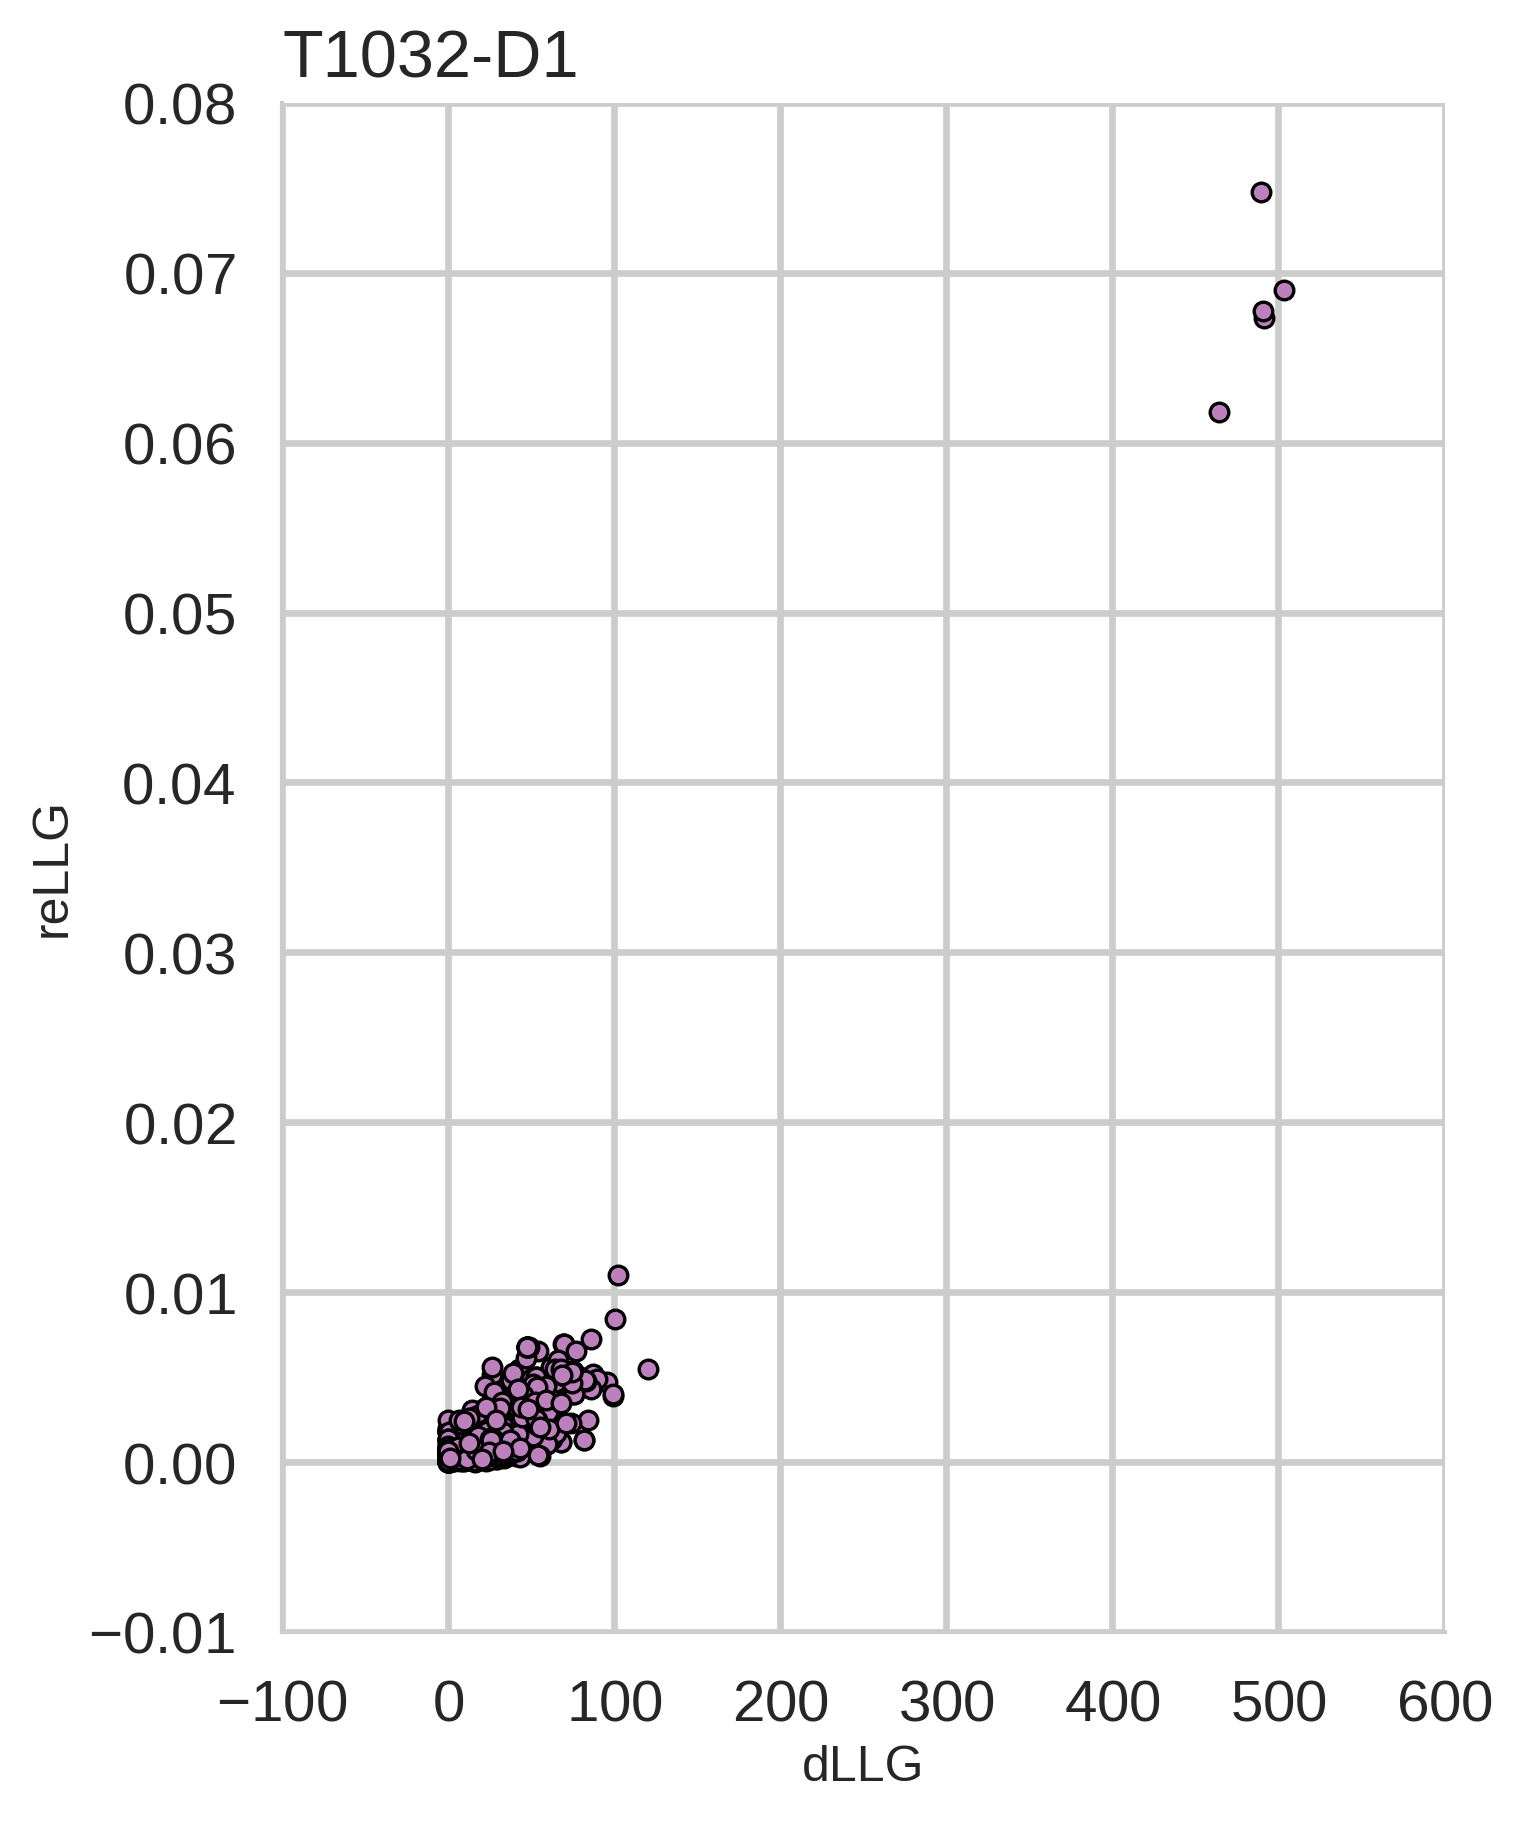

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])
################################################################
# Analysis of specific targets of interest                    #
# T1032-D1:  TBM-hard case, 6 copies in a.u., data to 3.3 Å   #
###############################################################

# df_llg_data
subset_llg_t1032 = df_llg_data.loc[df_llg_data['Model'].str.startswith('T1032') & df_llg_data['Model'].str.endswith('D1')]
#display(subset_llg_t1032)
#print("Size subset llg",len(subset_llg_t1032))


# with column set to a constant bfactor
#########################################

#df_bcons
subset_bcons_t1032 = df_bcons.loc[df_bcons['Model'].str.startswith('T1032') & df_bcons['Model'].str.endswith('D1')]
#display(subset_bcons_t1032)
#print("Size subset bcons",len(subset_bcons_t1032))
merge_for_scatter_bcons_t1032 = pd.merge(subset_llg_t1032,subset_bcons_t1032)
#display(merge_for_scatter_bcons_t1032)
# columns of interest for this scatter will be LLG_const_B_deltaLLG and reLLG_bfactor_constant
#print("size of merge ",merge_for_scatter_bcons_t1032)
plotted_bcons = merge_for_scatter_bcons_t1032.plot.scatter(x='LLG_const_B_deltaLLG',y='reLLG_bfactor_constant',figsize=(5,6.75),s=20,fontsize=14)
plotted_bcons.set_title("T1032-D1")
plotted_bcons.set_xlabel("dLLG")
plotted_bcons.set_ylabel("reLLG")


Text(0, 0.5, 'reLLG')

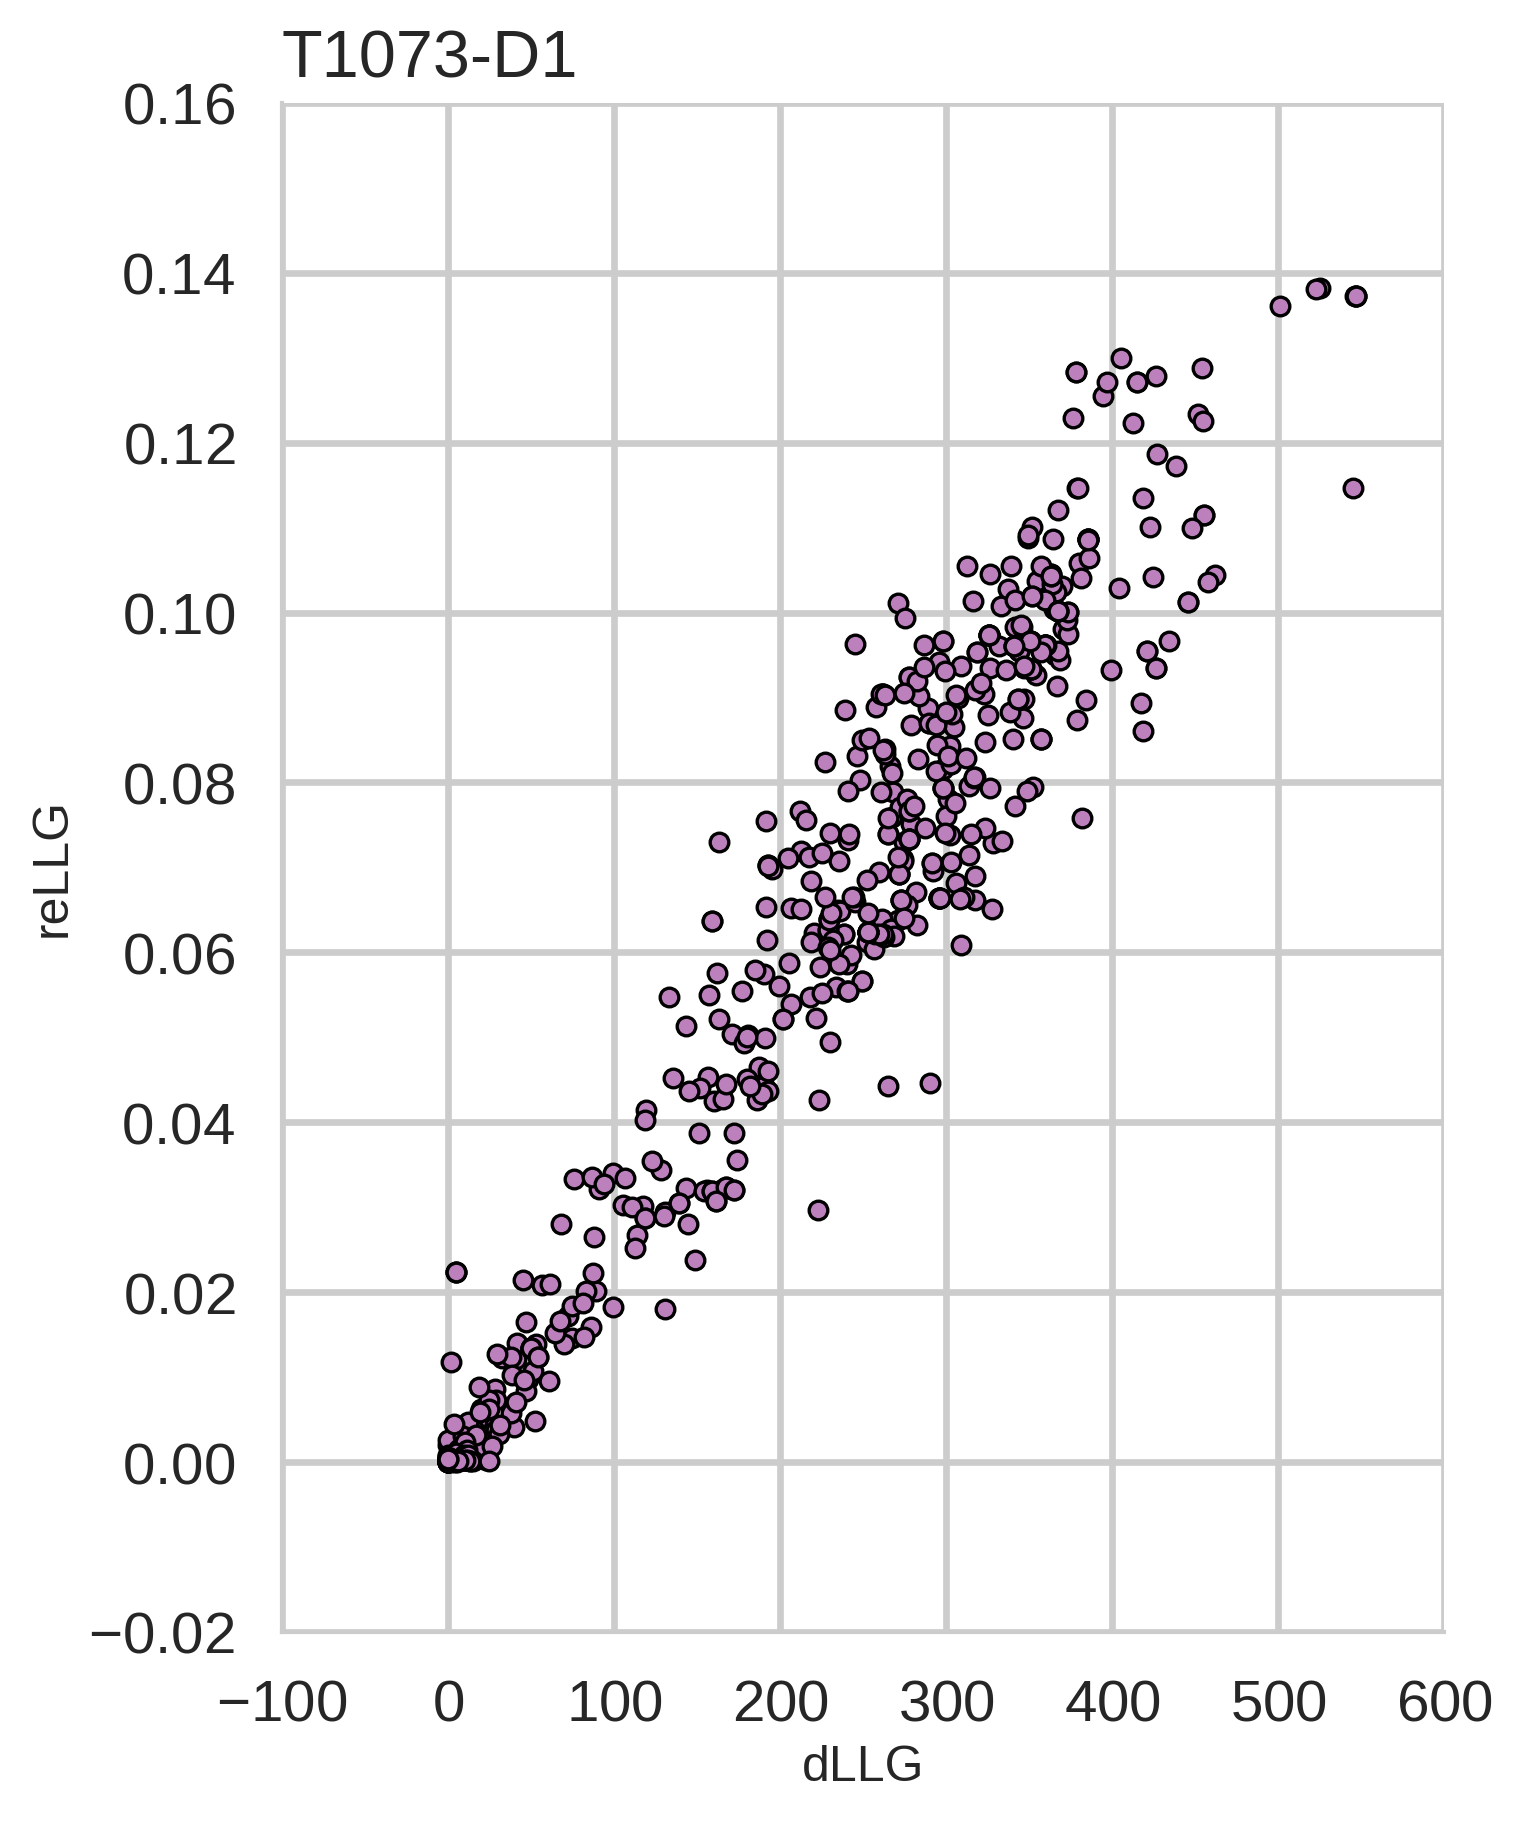

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])
# Analysis of specific targets of interest
#T1073-D1:  TBM-easy case, 2 copies, complete molecule, data to 1.9 Å


# df_llg_data
subset_llg_t1073 = df_llg_data.loc[df_llg_data['Model'].str.startswith('T1073') & df_llg_data['Model'].str.endswith('D1')]
#display(subset_llg_t1073)
#print("Size subset llg",len(subset_llg_t1073))


# with column set to a constant bfactor
#########################################

#df_bcons
subset_bcons_t1073 = df_bcons.loc[df_bcons['Model'].str.startswith('T1073') & df_bcons['Model'].str.endswith('D1')]
#display(subset_bcons_t1073)
#print("Size subset bcons",len(subset_bcons_t1073))

merge_for_scatter_bcons_t1073 = pd.merge(subset_llg_t1073,subset_bcons_t1073)
#display(merge_for_scatter_bcons_t1073)
# columns of interest for this scatter will be LLG_const_B_deltaLLG and reLLG_bfactor_constant
plotted_bcons = merge_for_scatter_bcons_t1073.plot.scatter(x='LLG_const_B_deltaLLG',y='reLLG_bfactor_constant',figsize=(5,6.75),s=20,fontsize=14)
plotted_bcons.set_title("T1073-D1")
plotted_bcons.set_xlabel("dLLG")
plotted_bcons.set_ylabel("reLLG")




Text(0, 0.5, 'reLLG')

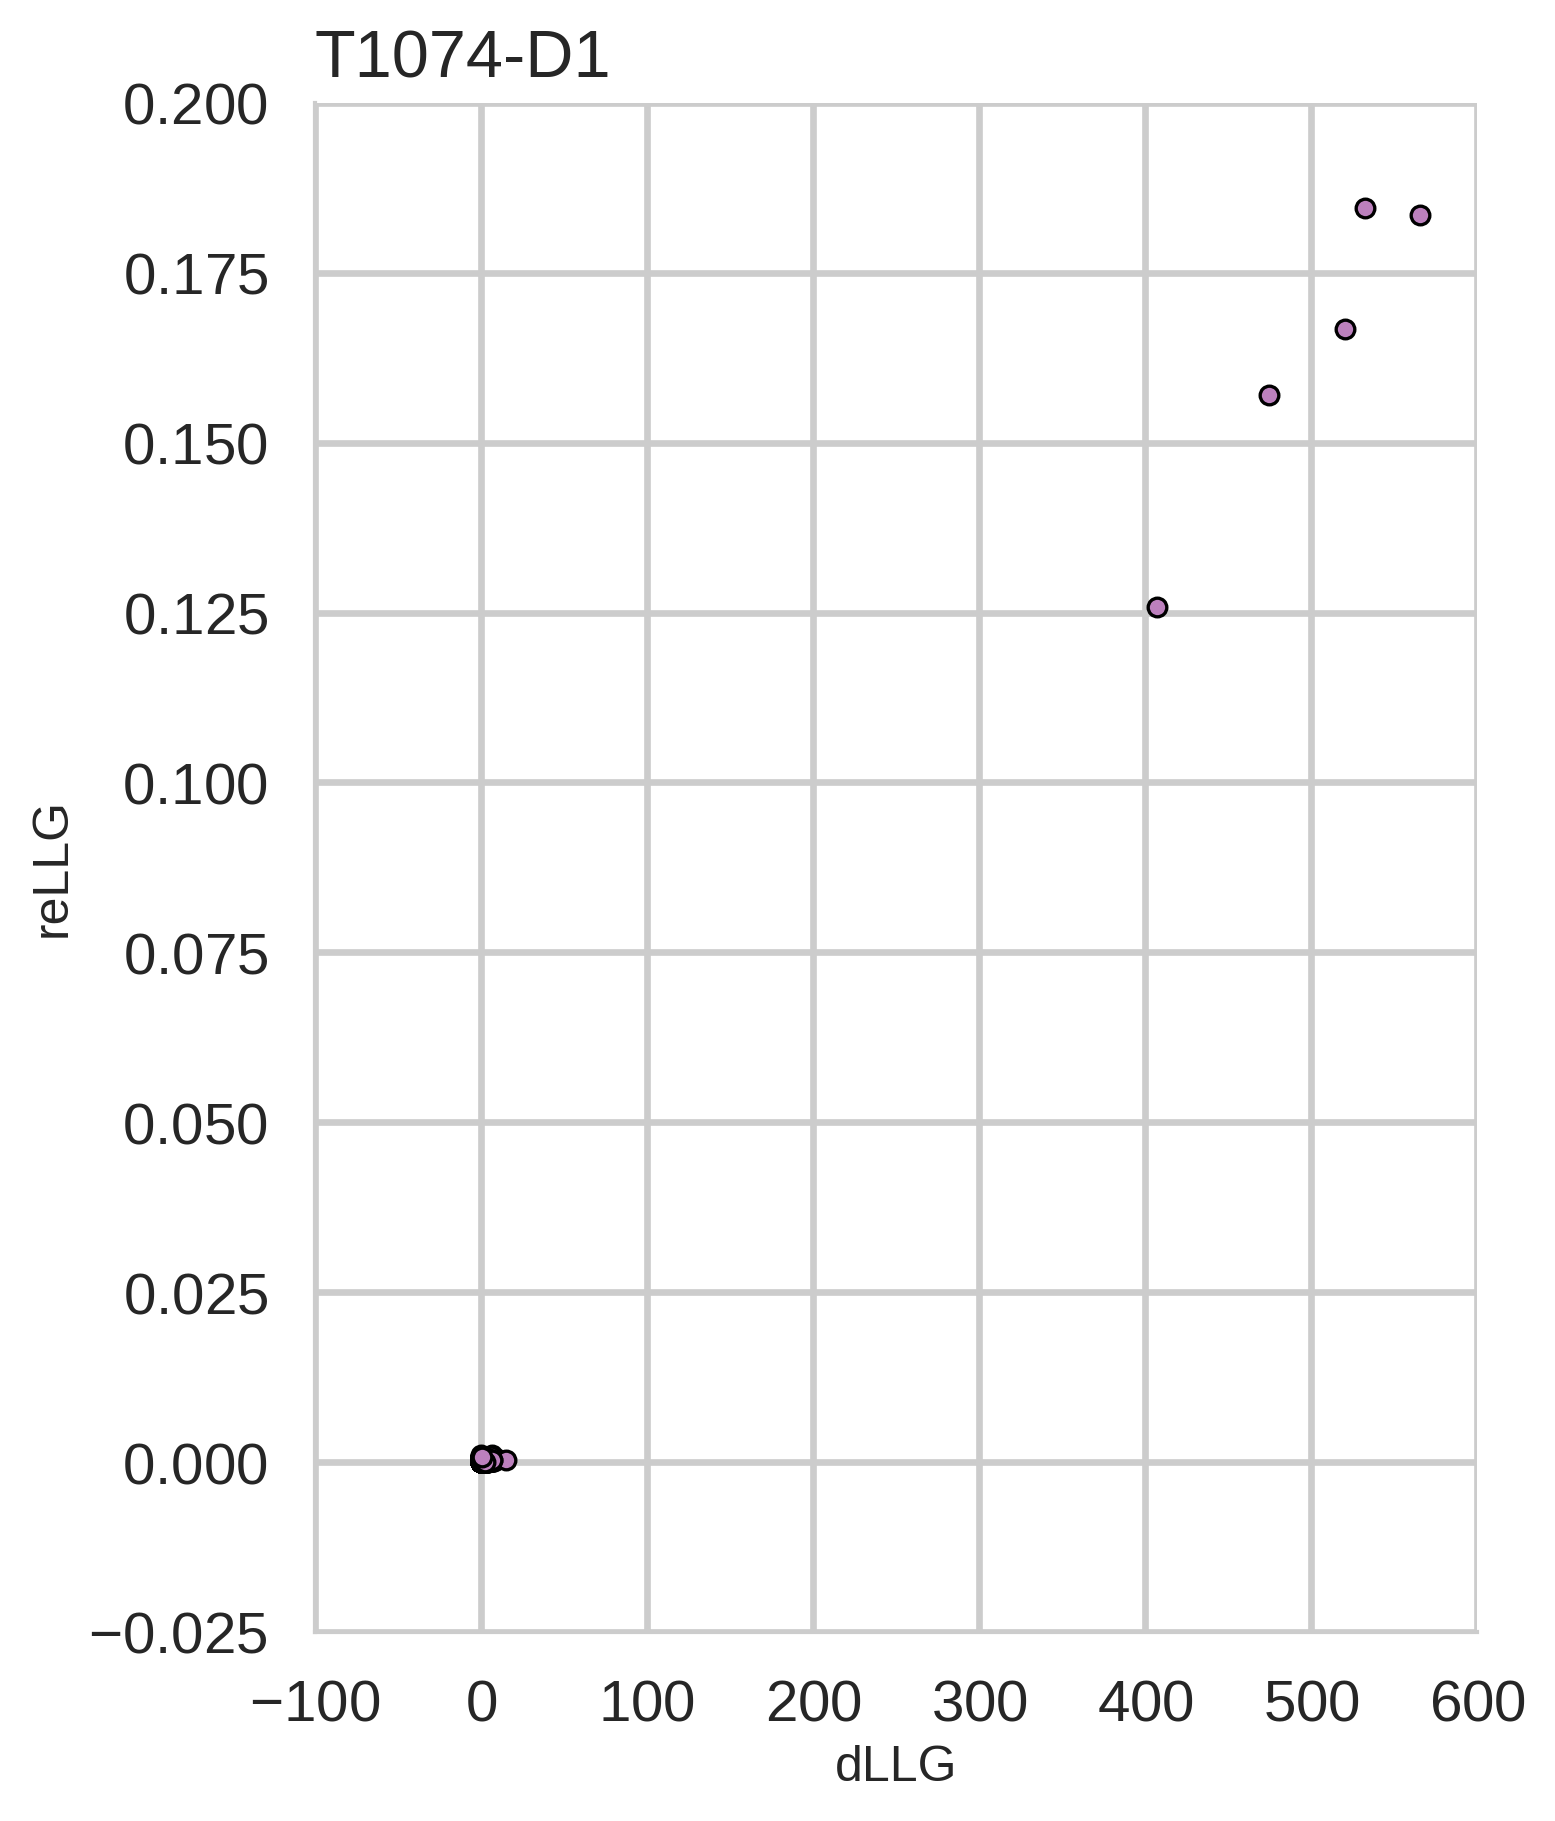

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])
# Analysis of specific targets of interest
#T1074-D1:  FM case, 1 copy, complete molecule, data to 1.5 Å

# df_llg_data
subset_llg_t1074 = df_llg_data.loc[df_llg_data['Model'].str.startswith('T1074') & df_llg_data['Model'].str.endswith('D1')]
#display(subset_llg_t1074)
#print("Size subset llg",len(subset_llg_t1074))

# with column set to a constant bfactor
#########################################

#df_bcons
subset_bcons_t1074 = df_bcons.loc[df_bcons['Model'].str.startswith('T1074') & df_bcons['Model'].str.endswith('D1')]
#display(subset_bcons_t1074)
#print("Size subset bcons",len(subset_bcons_t1074))
merge_for_scatter_bcons_t1074 = pd.merge(subset_llg_t1074,subset_bcons_t1074)
#display(merge_for_scatter_bcons_t1074)
#print("size of merge ",len(merge_for_scatter_bcons_t1074))
# columns of interest for this scatter will be LLG_const_B_deltaLLG and reLLG_bfactor_constant
plotted_bcons=merge_for_scatter_bcons_t1074.plot.scatter(x='LLG_const_B_deltaLLG',y='reLLG_bfactor_constant',figsize=(5,6.75),s=20,fontsize=14)
plotted_bcons.set_title('T1074-D1')
plotted_bcons.set_xlabel("dLLG")
plotted_bcons.set_ylabel("reLLG")


In [ ]:


# Overall ranking of the groups by their average z-score considering only their model 1

###########
# AS_RMSD #
###########


# For every target_evaluation that a group did not cover we need to add a dummy model 1 and penalise it with a -2
temp_data = df_all_as_rmsd.copy(deep=True)
penalised = include_penalization(temp_data,'as_rmsd',list_target_evaluation)
df_mod1_as_rmsd = penalised


BEFORE ADDING PENALIZATION 10716
AFTER ADDING PENALIZATION 14016


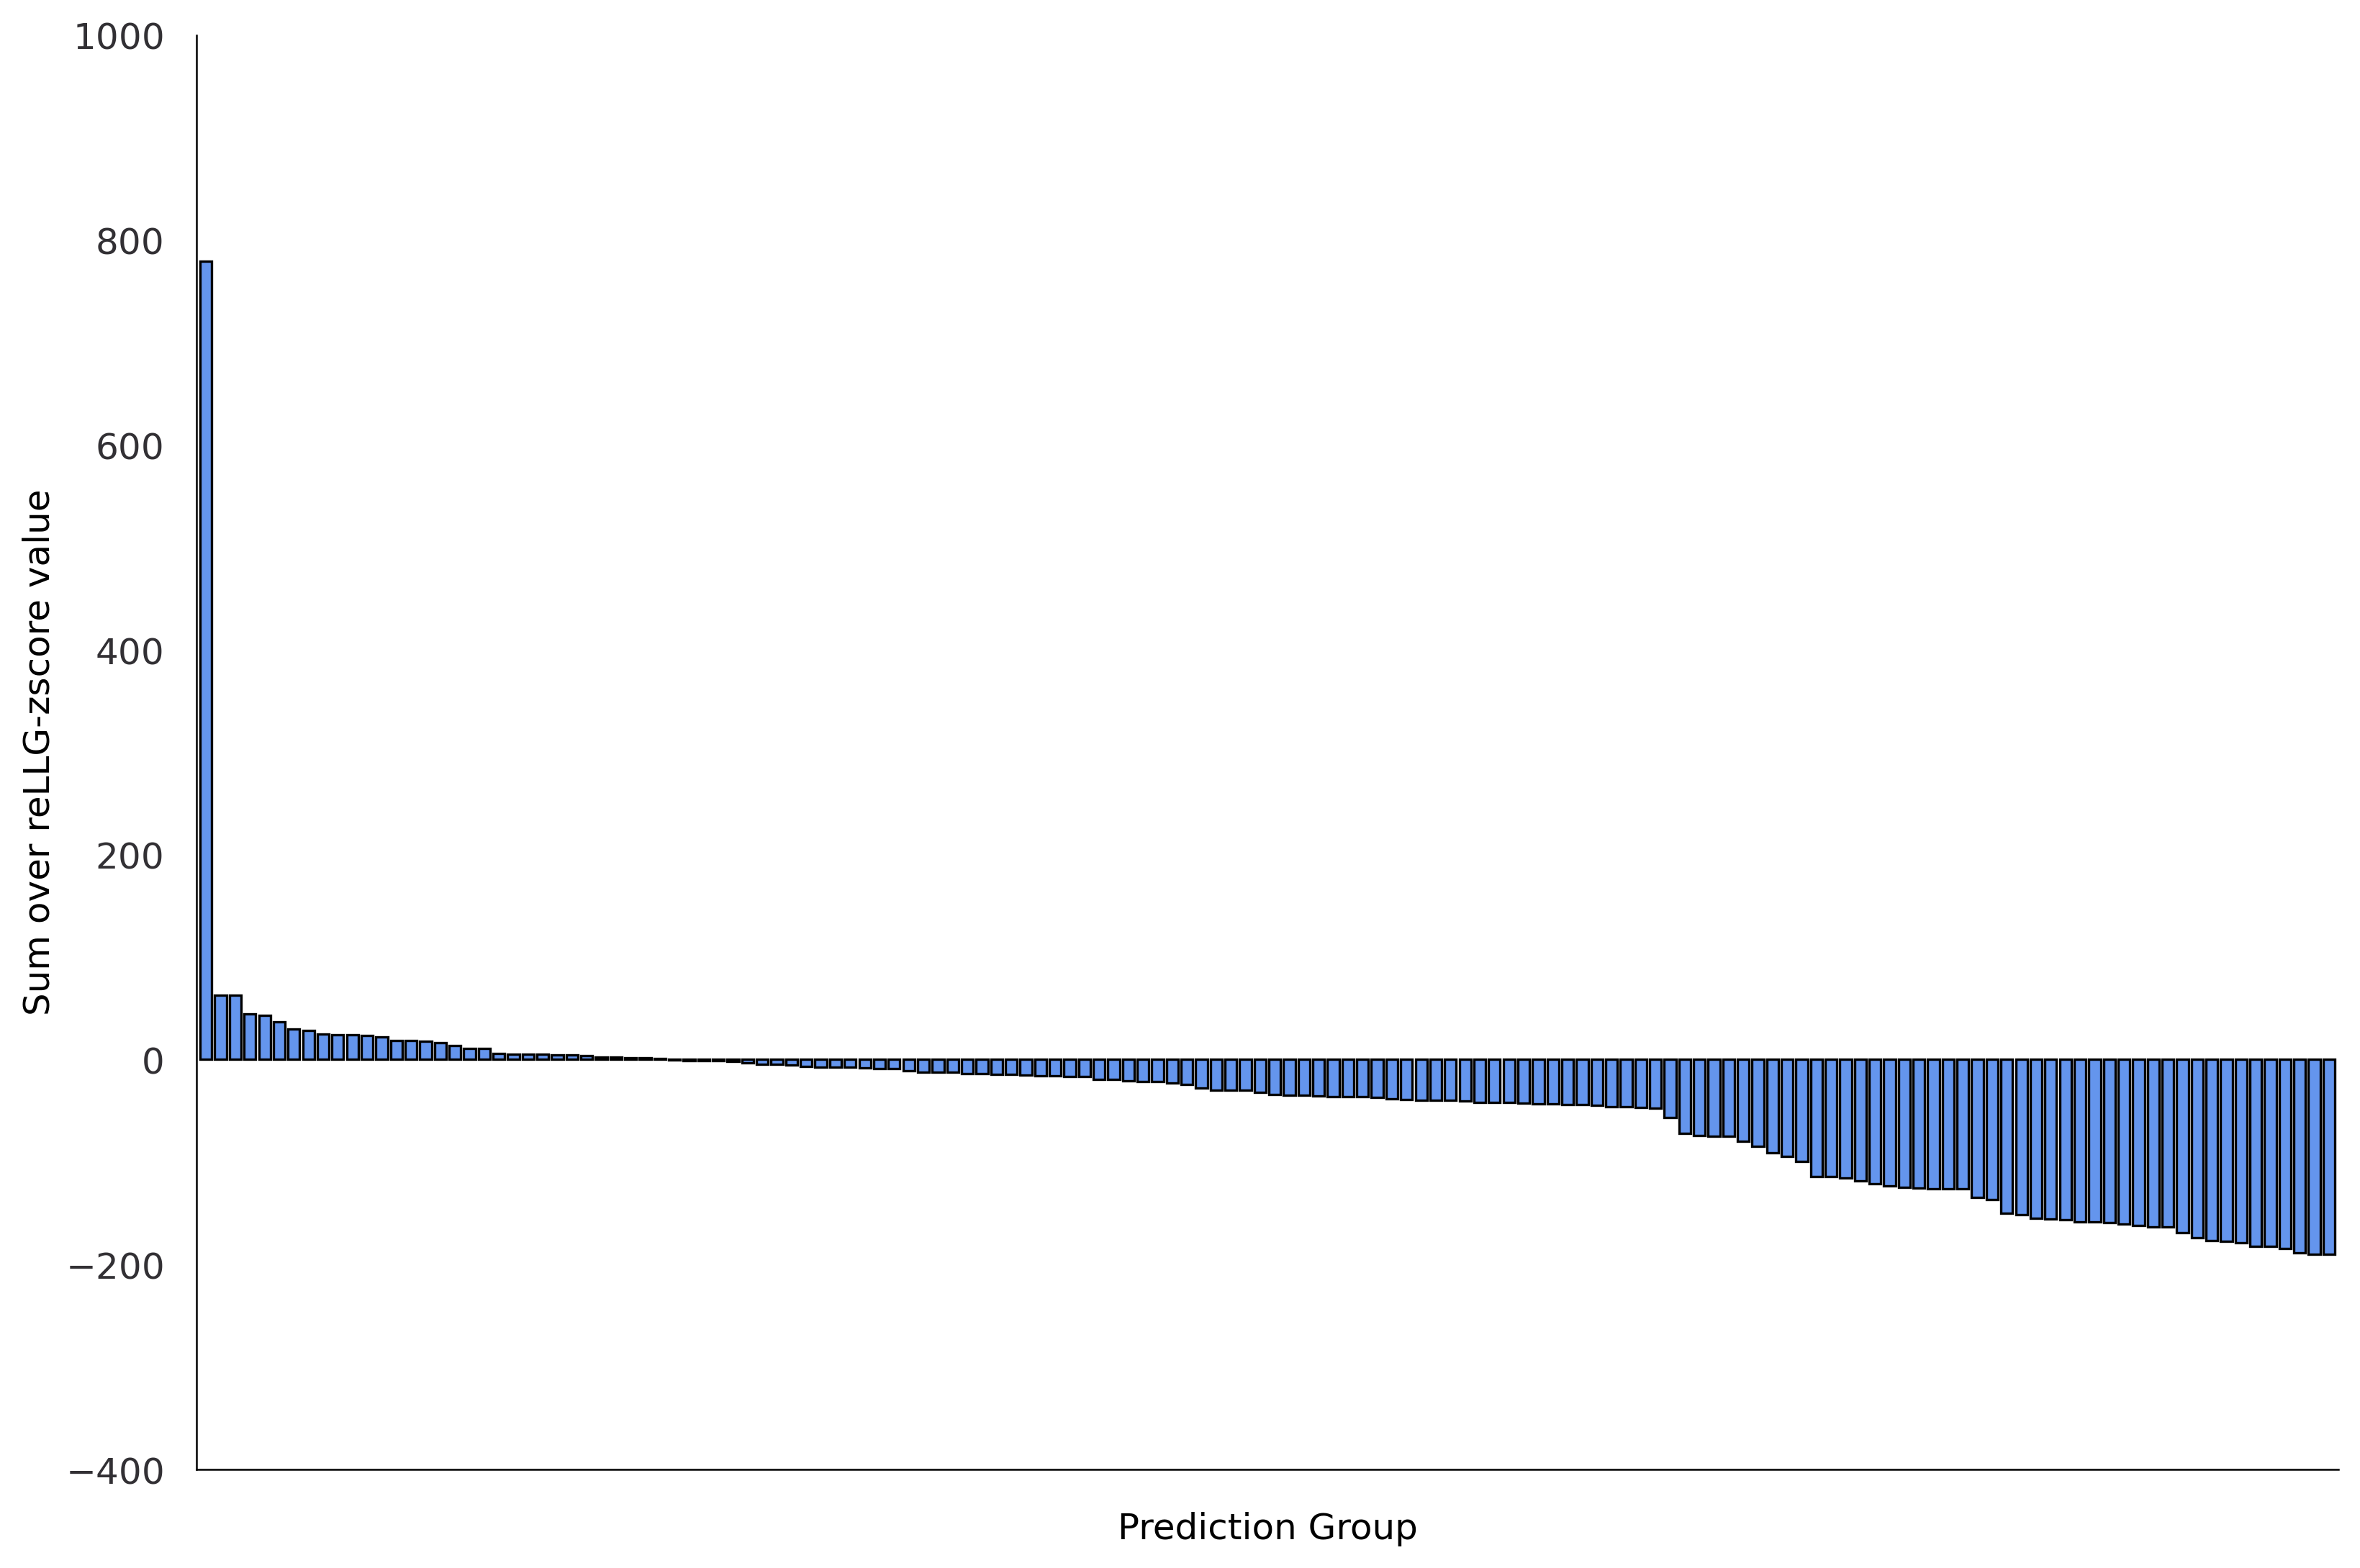

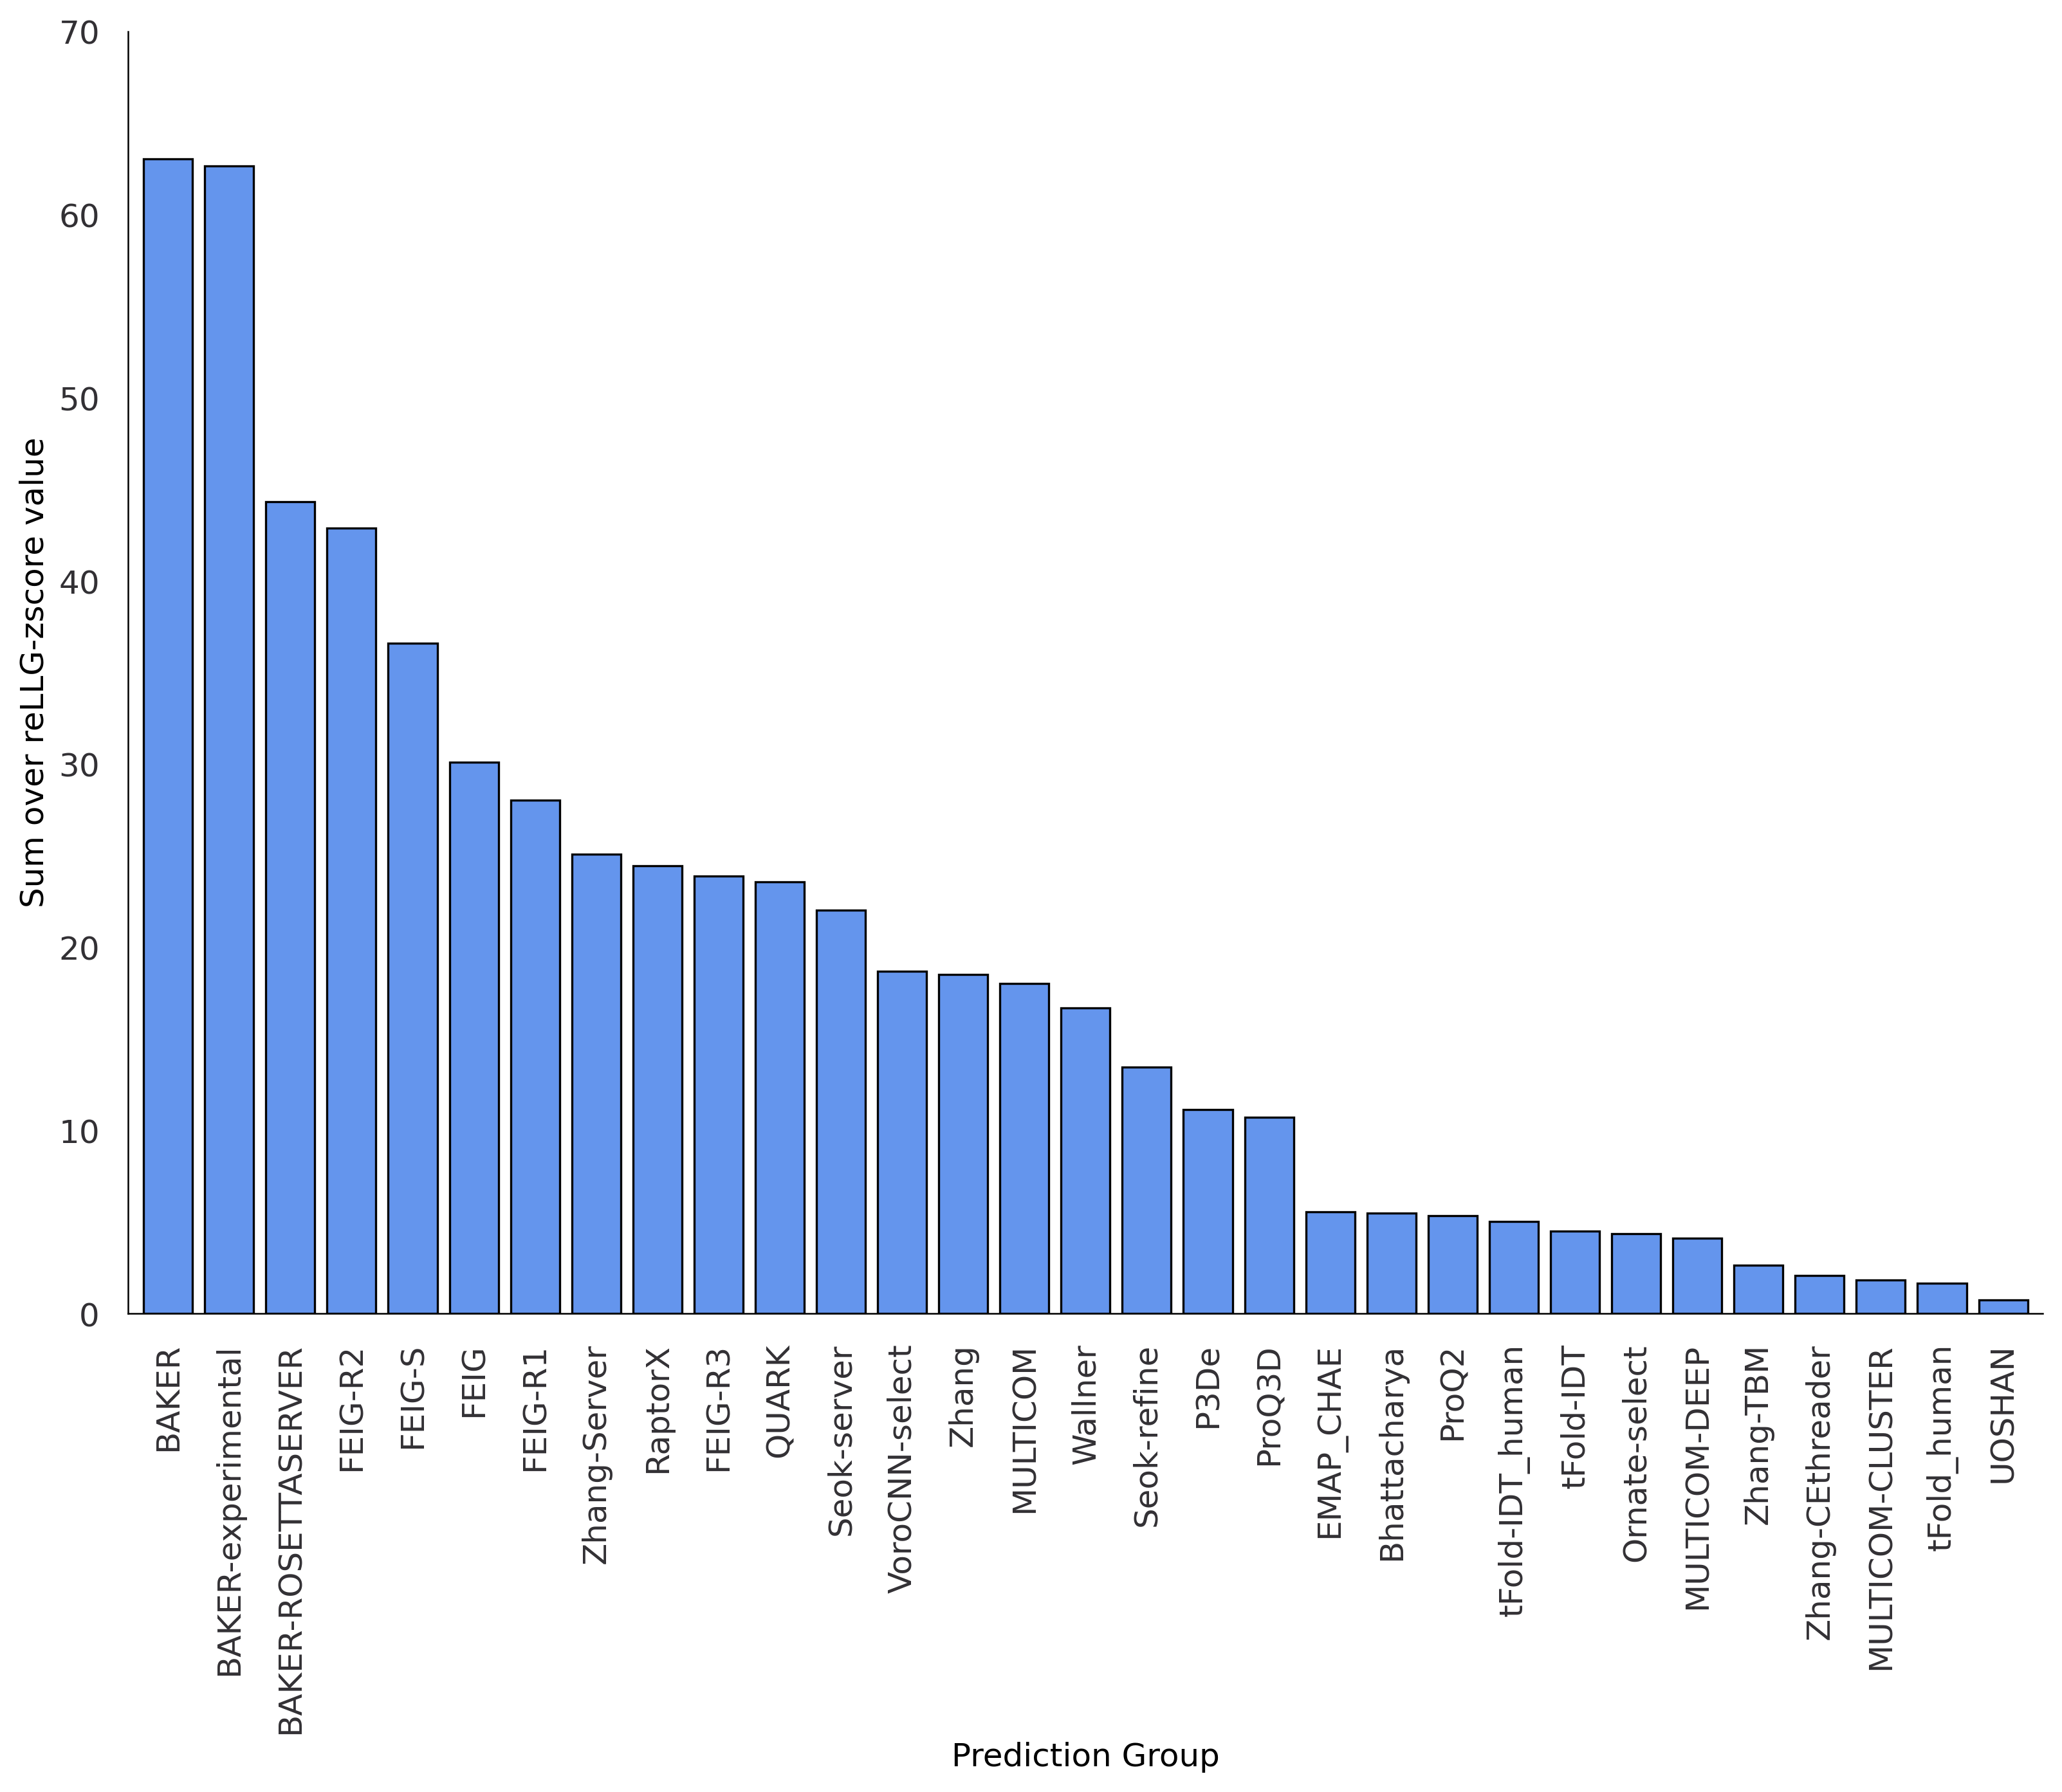

,Sum_reLLG_as_rmsd_zscore,Name_Group
Name_Group,,
AlphaFold2,779.436639,AlphaFold2
BAKER,63.039433,BAKER
BAKER-experimental,62.656890,BAKER-experimental
BAKER-ROSETTASERVER,44.305595,BAKER-ROSETTASERVER
FEIG-R2,42.863823,FEIG-R2
FEIG-S,36.580241,FEIG-S
FEIG,30.084656,FEIG
FEIG-R1,28.015578,FEIG-R1
Zhang-Server,25.050206,Zhang-Server


Text(0.06, 0.5, 'sum over Z-score')

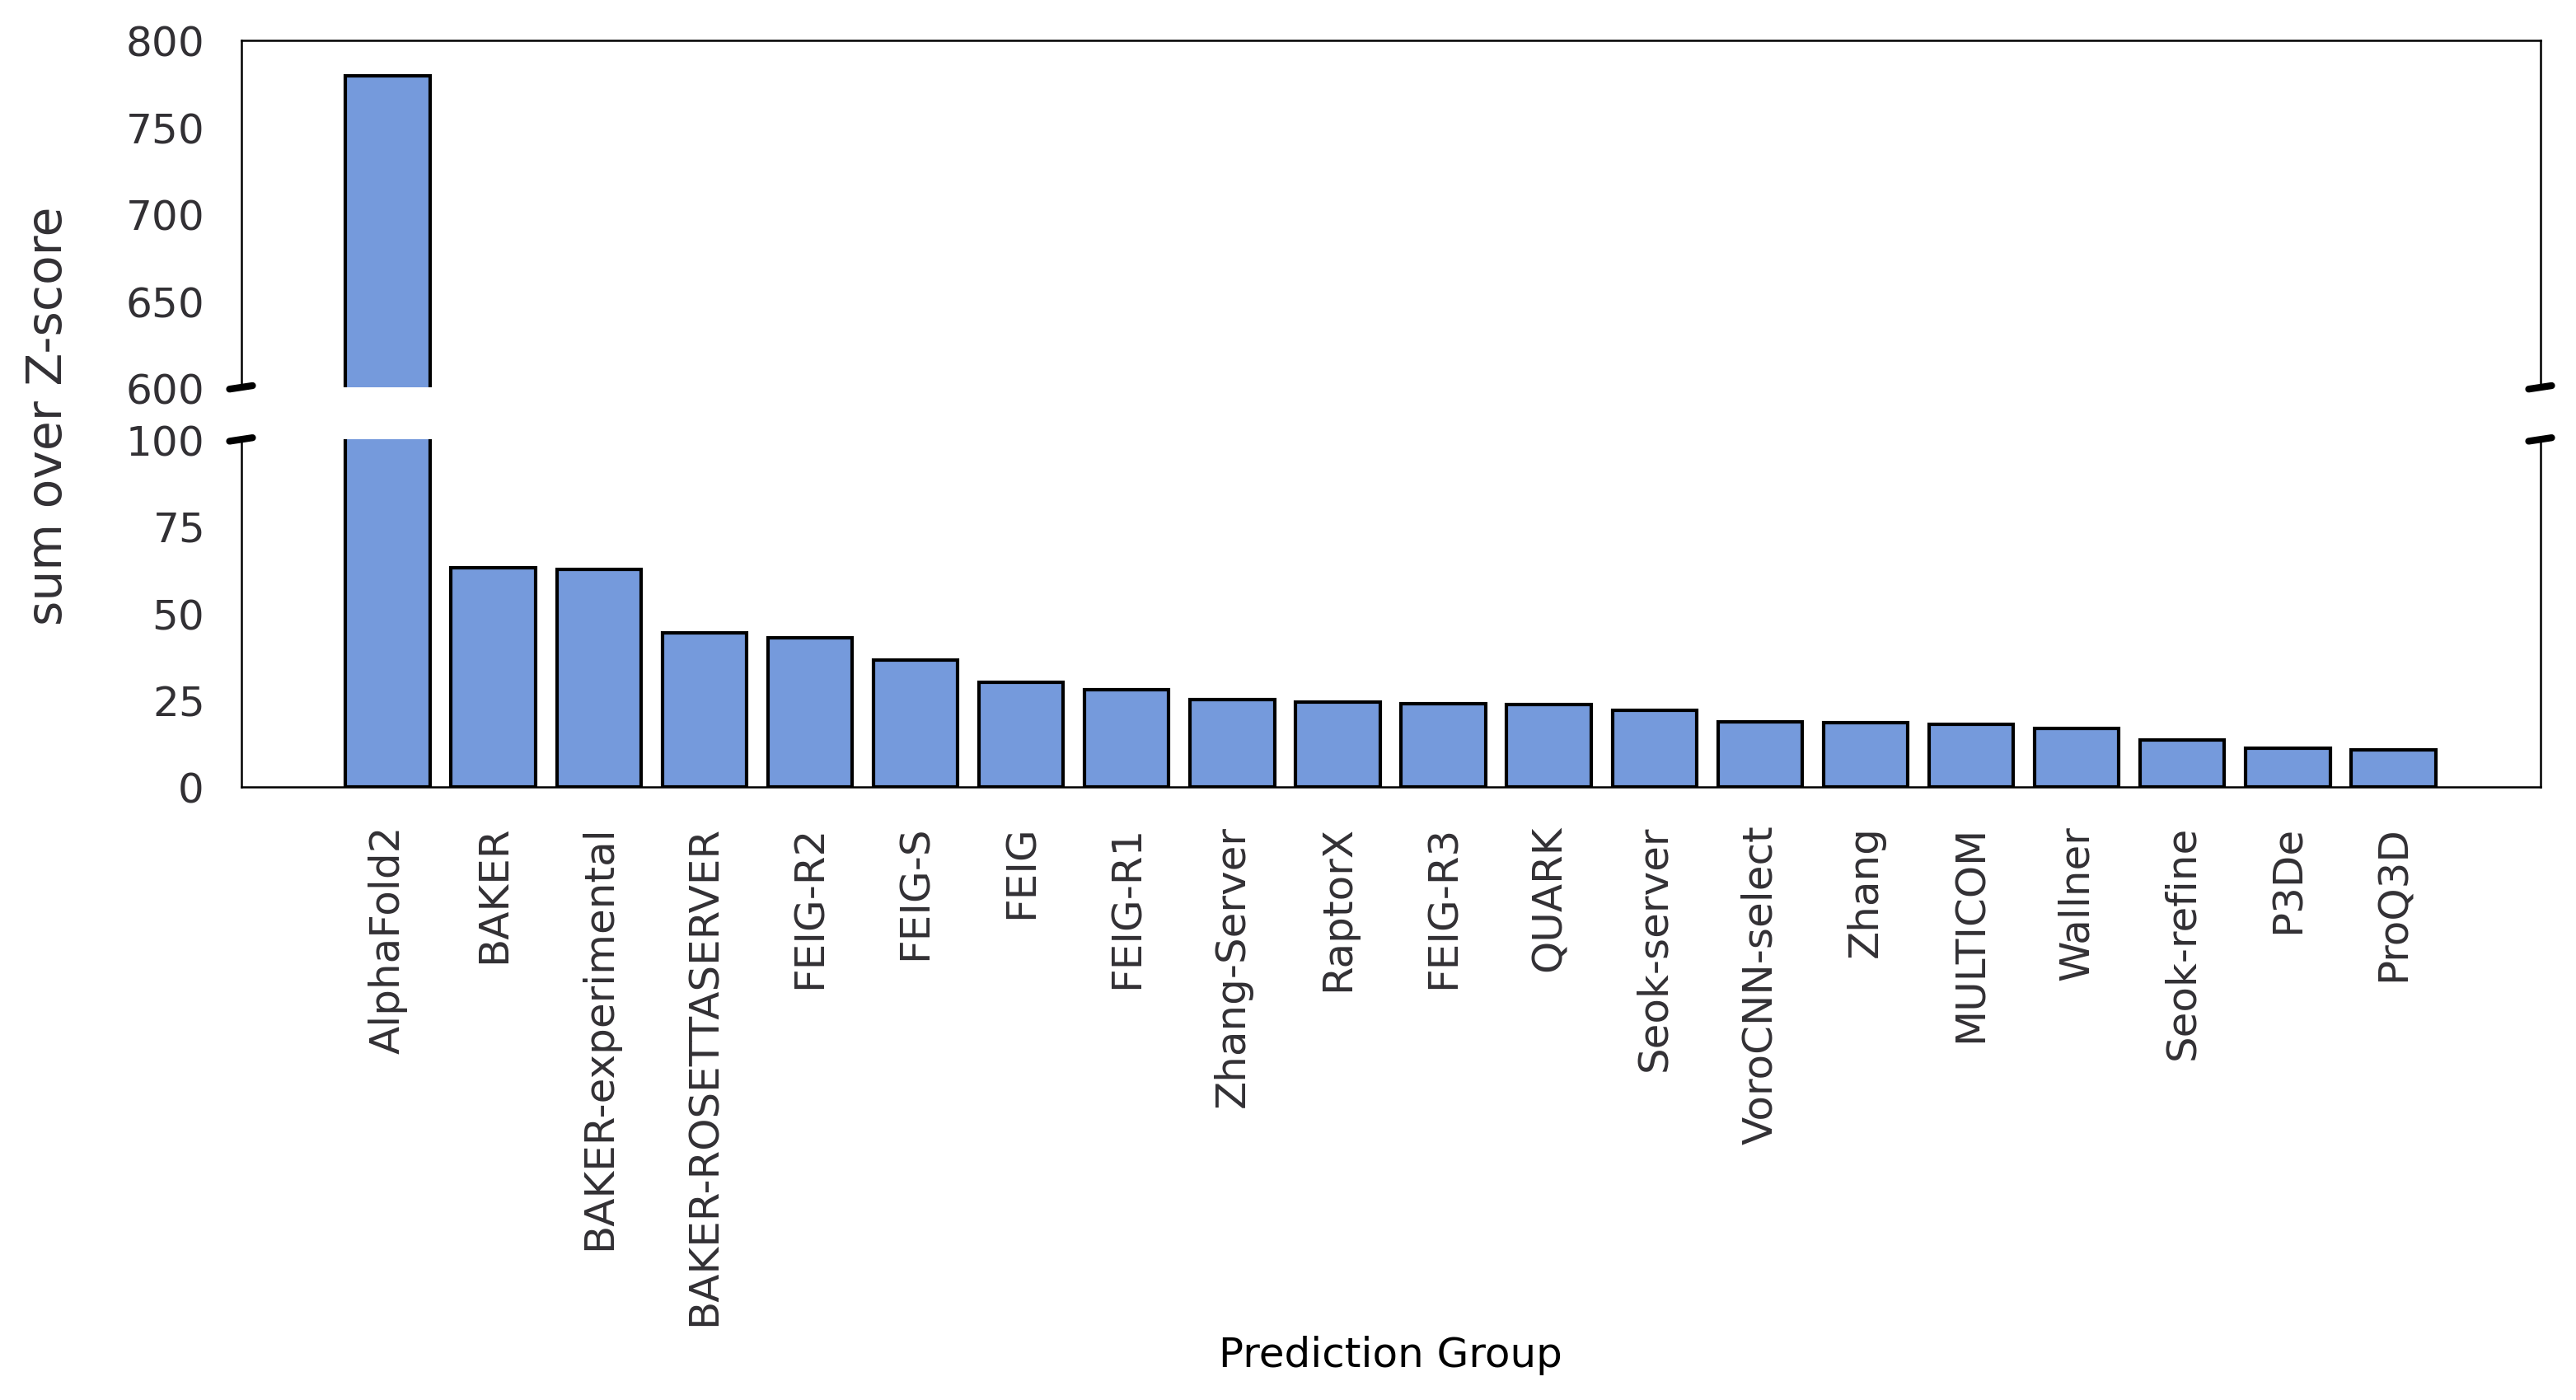

In [ ]:
#plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle'])
#plt.style.use(['seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'
# Rank on the zscore and using the sum (already using penalization)
rank_model_1_as_rmsd_zscore_sum, plot_rank_model_1_as_rmsd_zscore_sum = compute_ranking_and_plot(df_mod1_as_rmsd,'reLLG_as_rmsd_zscore','sum')
# We can now modify the plot
plot_rank_model_1_as_rmsd_zscore_sum.set_xticklabels([])
plot_rank_model_1_as_rmsd_zscore_sum.set_xlabel("Prediction Group")
plot_rank_model_1_as_rmsd_zscore_sum.set_ylabel("Sum over reLLG-zscore value")
plt.show()
# now a version without alphafold and the negatives
filtered_df = df_mod1_as_rmsd[df_mod1_as_rmsd['Name_Group']!="AlphaFold2"]
#display(filtered_df)
rank_filtered, plot_rank_model_1_filtered = compute_ranking_and_plot(filtered_df,'reLLG_as_rmsd_zscore','sum',filter_negative=True)
plot_rank_model_1_filtered.set_xlabel("Prediction Group")
plot_rank_model_1_filtered.set_ylabel("Sum over reLLG-zscore value")
plt.show()

datasum = pd.DataFrame(rank_model_1_as_rmsd_zscore_sum)
datasum['Name_Group'] = datasum.index
datasum.columns = ['Sum_reLLG_as_rmsd_zscore','Name_Group']
datasum = datasum.nlargest(20,'Sum_reLLG_as_rmsd_zscore')
display(datasum)

# Trying to get the broken axis one with the code from Joana's example
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
fig.subplots_adjust(hspace=0.15)  # adjust space between axes
sns.barplot(x='Name_Group', y='Sum_reLLG_as_rmsd_zscore', data=datasum, palette=['cornflowerblue'], linewidth=1, edgecolor='black', ax=ax1)
sns.barplot(x='Name_Group', y='Sum_reLLG_as_rmsd_zscore', data=datasum, palette=['cornflowerblue'], linewidth=1, edgecolor='black', ax=ax2)
ax1.set_ylim(bottom=600,top=800)  # outliers only (upper part)
ax2.set_ylim(0, 100)  # most of the data (bottom part)
#print(ax1.spines)
#print(ax2.spines)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.legend([],[], frameon=False)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('Prediction Group')
fig.text(0.06, 0.5, 'sum over Z-score', ha='center', va='center', rotation='vertical',fontsize=14)






,Name_Group,LLG_kind,Sum
0,AlphaFold2,dLLG,429.035346
1,AlphaFold2,reLLG,470.862366
2,BAKER,dLLG,50.232149
3,BAKER,reLLG,40.671263
4,BAKER-experimental,dLLG,50.214324
5,BAKER-experimental,reLLG,35.132266
6,FEIG,dLLG,40.703078
7,FEIG,reLLG,30.817945
8,BAKER-ROSETTASERVER,dLLG,36.766363
9,BAKER-ROSETTASERVER,reLLG,26.576334


Text(0.06, 0.5, 'sum over Z-score of metric')

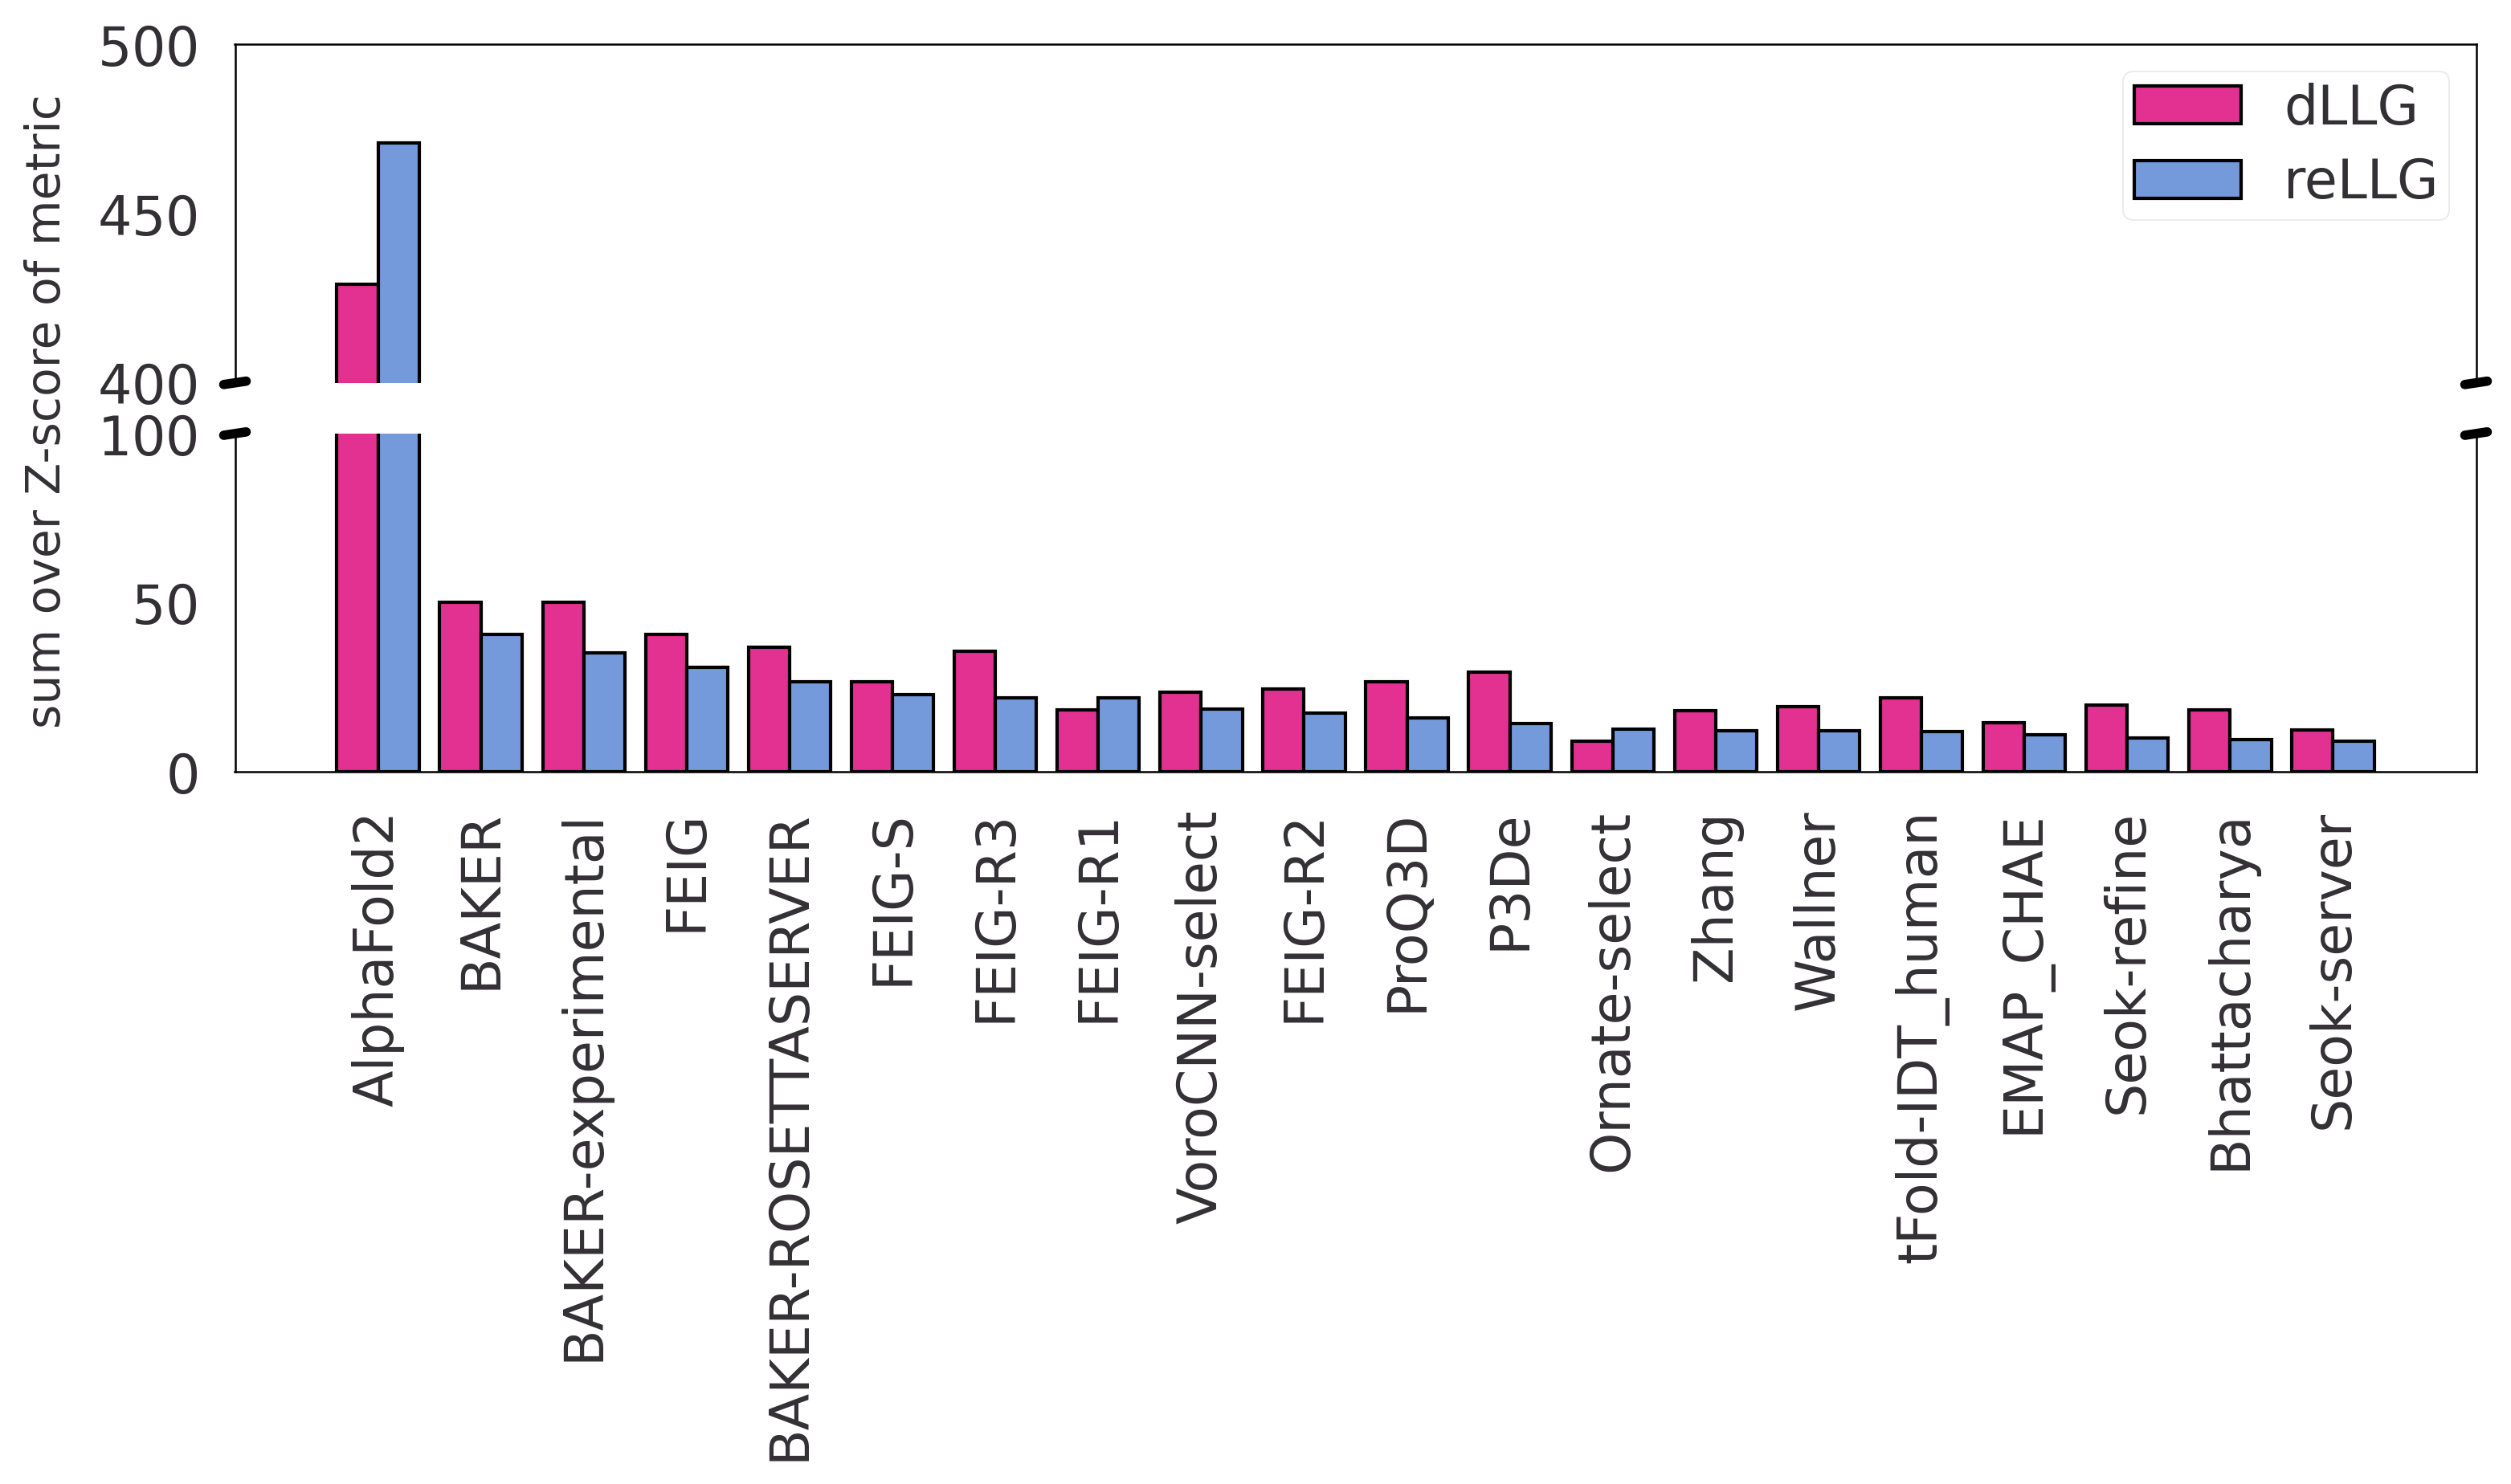

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'

#################################################################################################
# Do the ranking only with those targets for which there is data for doing the llg calculation. #
#################################################################################################

#print(list_subset_targets_with_llg_data)
filtered_df_llg = df_mod1_as_rmsd.copy(deep=True) 
#print('Before')
#display(filtered_df_llg)
filtered_df_llg = filtered_df_llg.loc[filtered_df_llg['Target_Evaluation'].isin(list_subset_targets_with_llg_data)]
#print('After')
#display(filtered_df_llg)

#rank_model_1_as_rmsd_zscore_sum_LLG, plot_rank_model_1_as_rmsd_zscore_sum_LLG = compute_ranking_and_plot(filtered_df_llg,'reLLG_as_rmsd_zscore','sum',color='mediumseagreen')
# We can now modify the plot
#plot_rank_model_1_as_rmsd_zscore_sum_LLG.set_xticklabels([])
#plot_rank_model_1_as_rmsd_zscore_sum_LLG.set_xlabel("Prediction Group")
#plot_rank_model_1_as_rmsd_zscore_sum_LLG.set_ylabel("Sum over reLLG-zscore value")
#plt.show()
# now a version without alphafold and the negatives
#filtered_df_noalpha = filtered_df_llg[filtered_df_llg['Name_Group']!="AlphaFold2"]
#rank_filtered_LLG, plot_rank_model_1_filtered_LLG = compute_ranking_and_plot(filtered_df_noalpha,'reLLG_as_rmsd_zscore','sum',filter_negative=True,color='mediumseagreen')
#plot_rank_model_1_filtered_LLG.set_xlabel("Prediction Group")
#plot_rank_model_1_filtered_LLG.set_ylabel("Sum over reLLG-zscore value")
#plt.show()


#################################################################################################
# Do a top 20 plot comparing the dLLG and reLLG, broken axis for alphafold                      #
#################################################################################################
# The filtered_df_llg is my reLLG data but only for the targets for which there is also LLG data.
#display(filtered_df_llg)
# Now I need to merge with the LLG data to be able to plot them side by side
# This is the LLG data, i think column for zscore is Z_LLG_B_from_rms_deltaLLG
#display(df_llg_data) # no info about name group here I need to retrieve it
merge_for_group = pd.merge(filtered_df_llg,df_llg_data,on='Model',how='left')
merge_for_group['Z_LLG_B_from_rms_deltaLLG'] = merge_for_group['Z_LLG_B_from_rms_deltaLLG'].fillna(-2)
merge_grouped = merge_for_group[['Model', 'reLLG_as_rmsd_zscore', 'Z_LLG_B_from_rms_deltaLLG','Name_Group']].copy()
#display(merge_grouped)
llg_by_group = merge_grouped.groupby(['Name_Group'])['Z_LLG_B_from_rms_deltaLLG'].sum()
rellg_by_group = filtered_df_llg.groupby(['Name_Group'])['reLLG_as_rmsd_zscore'].sum()
#display(llg_by_group)
#display(rellg_by_group)

# Check the dummies
merge_for_plot = pd.merge(llg_by_group,rellg_by_group,right_index = True,left_index = True)
#merge_for_plot = pd.merge(llg_by_group,rellg_by_group)
#display(merge_for_plot)

# we only want the top 20
top20 = merge_for_plot.nlargest(20,'reLLG_as_rmsd_zscore')
top20.sort_values('reLLG_as_rmsd_zscore', ascending=False, inplace=True)


#display(top20)
forplot = top20.copy(deep=True)
#forplot.reset_index(inplace=True)
forplot = forplot.stack().reset_index()
forplot.columns = ['Name_Group','LLG_kind','Sum']
forplot.replace({'Z_LLG_B_from_rms_deltaLLG':'dLLG','reLLG_as_rmsd_zscore':'reLLG'},inplace=True)
display(forplot)


# Normal plot
#ax = top20.plot.bar(color=['#999933','#aa4499'])
#ax.get_legend().remove()
#ax.set_xlabel("Prediction Group")
#ax.set_ylabel("Sum over z-score of metric")
#plt.xticks(rotation=90)
#plt.show()

# Trying to get the broken axis one with the code from Joana's example
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
fig.subplots_adjust(hspace=0.15)  # adjust space between axes
sns.barplot(x='Name_Group', y='Sum', data=forplot, hue='LLG_kind', palette=['#ff1493','#6495ED'], linewidth=1, edgecolor='black', ax=ax1)
sns.barplot(x='Name_Group', y='Sum', data=forplot, hue='LLG_kind', palette=['#ff1493','#6495ED'], linewidth=1, edgecolor='black', ax=ax2)

ax1.set_ylim(bottom=400,top=500)  # outliers only
ax2.set_ylim(0, 100)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(True)

ax2.legend([],[], frameon=False)

for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.set_ylabel('')
ax1.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel('')
#ax1.get_legend().remove()
ax1.legend_.set_title(None)
#new_labels = ['dLLG', 'reLLG']
#ax1.legend(labels=new_labels)
ax2.get_legend().remove()
fig.text(0.06, 0.5, 'sum over Z-score of metric', ha='center', va='center', rotation='vertical',fontsize=14)


In [ ]:
########################
# AS BFACTOR CONSTANT  #
########################

temp_data = df_all_bfact_constant.copy(deep=True)
#display(temp_data)
df_mod1_bfac_const = include_penalization(temp_data,'bfactor_constant',list_target_evaluation)

BEFORE ADDING PENALIZATION 10716
AFTER ADDING PENALIZATION 14016


Text(0, 0.5, 'reLLG average by group on NMR targets')

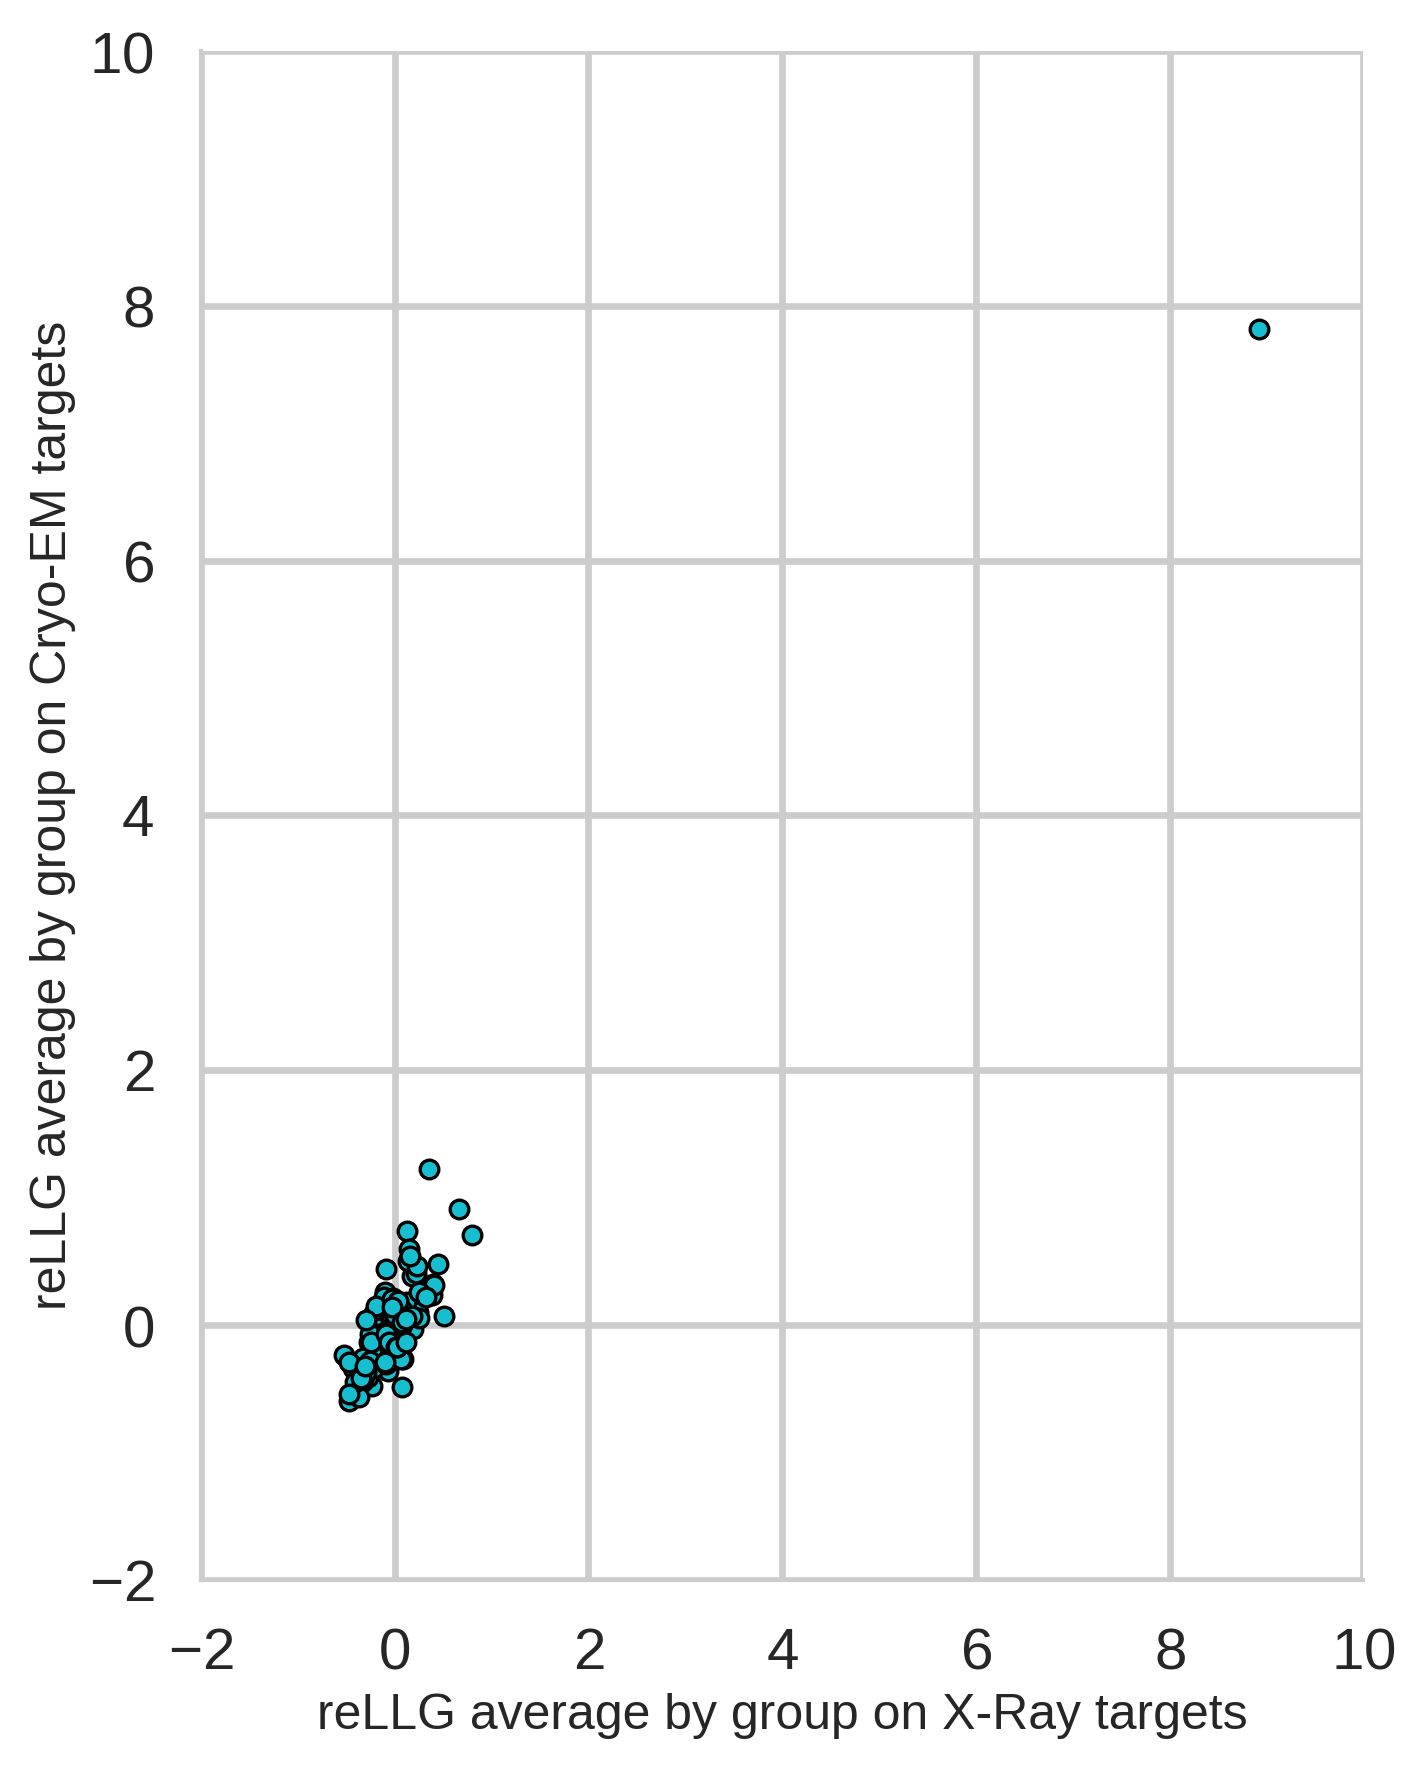

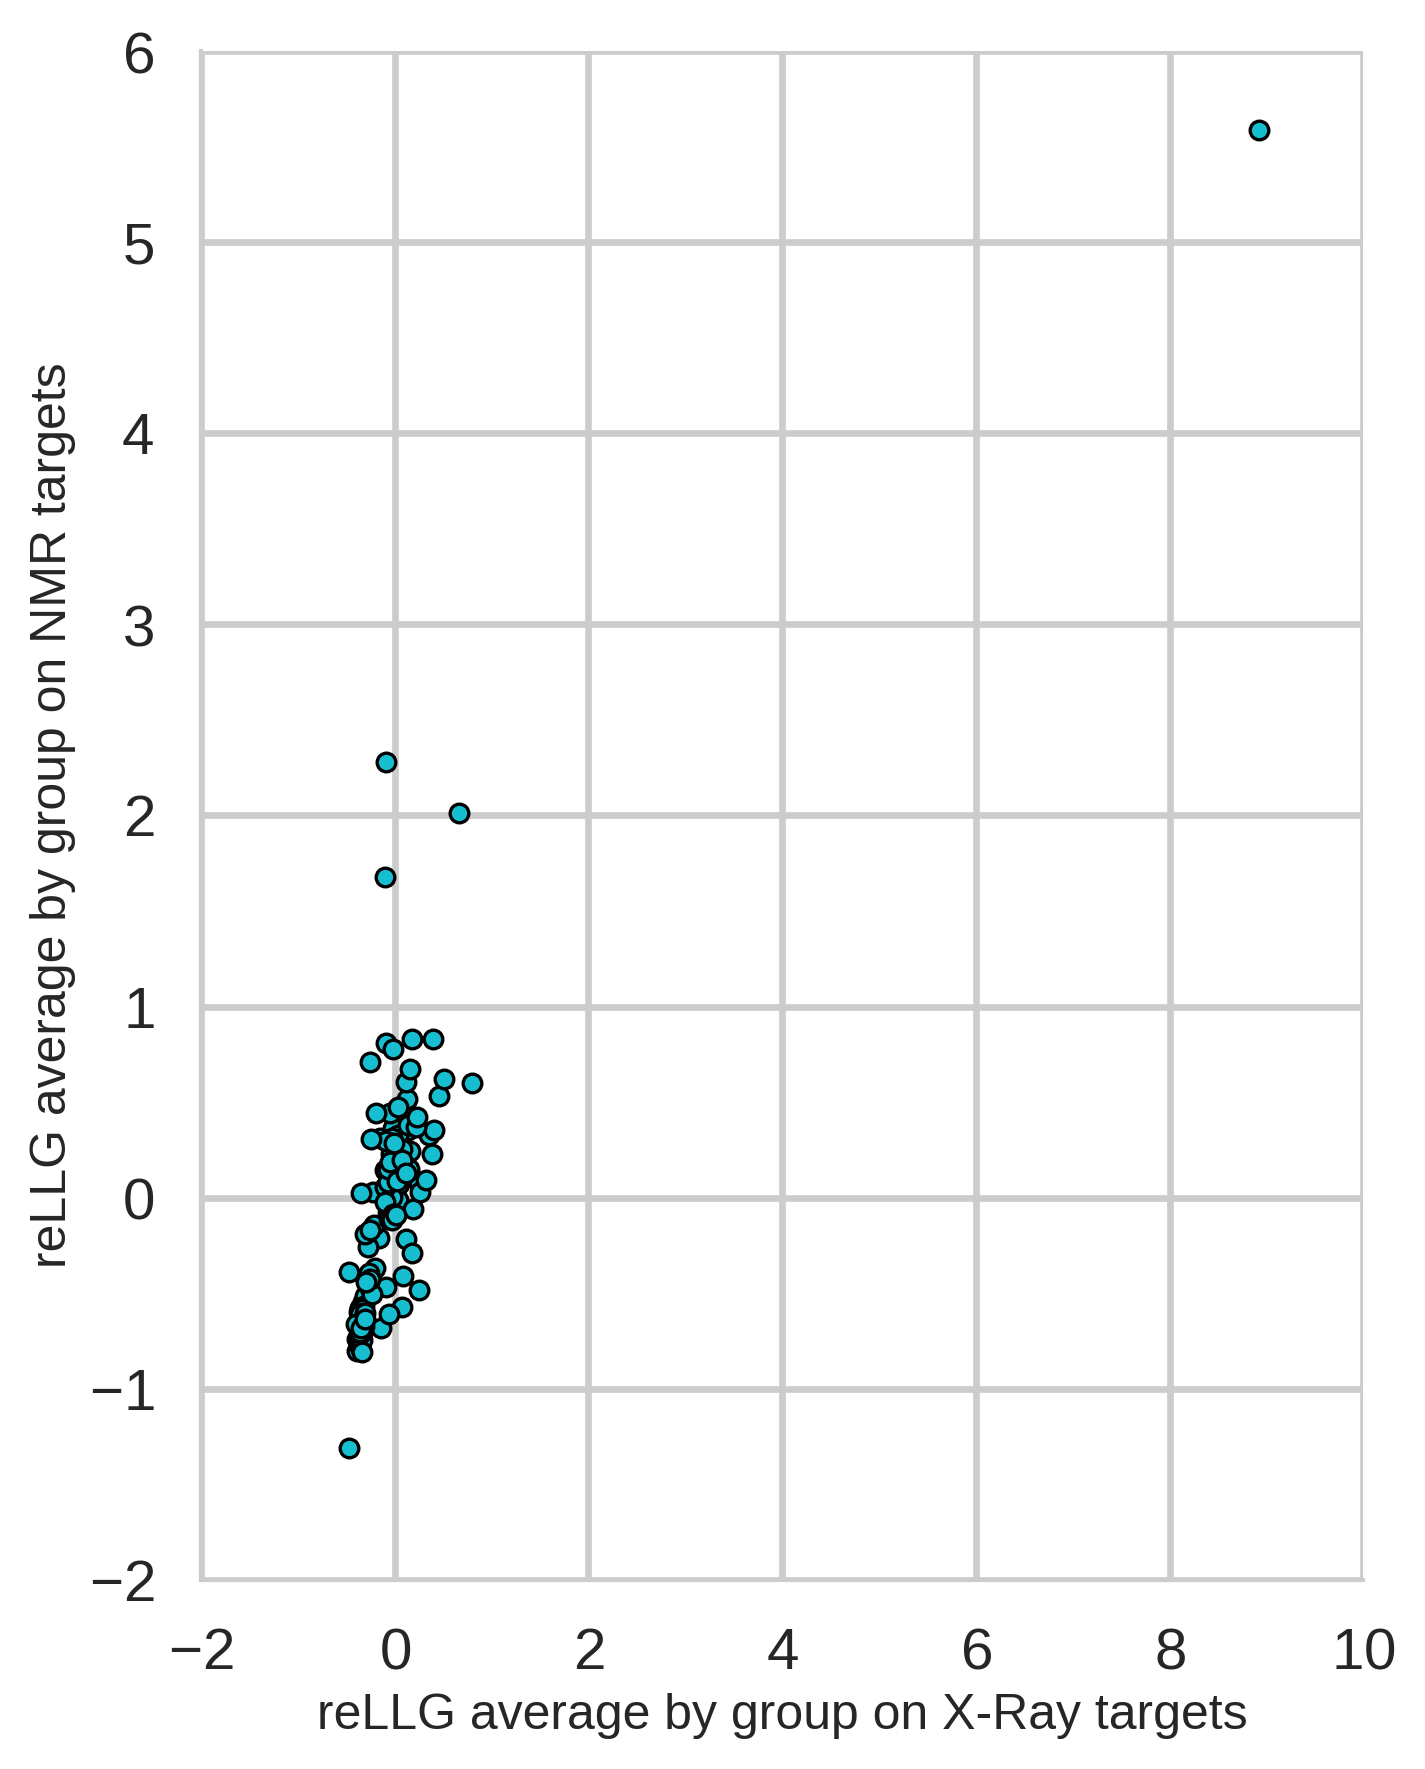

In [ ]:
plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-whitegrid'])
# Analysis of the effect on the score on the kind of experimental method

# Considering only the model_1
# As rmsd treatment
#display(df_mod1_as_rmsd)
grouped = df_mod1_as_rmsd.groupby(df_mod1_as_rmsd['Experimental_Method'])
mod1rmsd_xray = grouped.get_group("X-ray")
mod1rmsd_em = grouped.get_group("Cryo-EM")
mod1rmsd_nmr = grouped.get_group("NMR")
#display(mod1rmsd_xray)
#display(mod1rmsd_em)
#display(mod1rmsd_nmr)
as_rmsd_by_group_xray = mod1rmsd_xray.groupby(['Name_Group'])['reLLG_as_rmsd_zscore'].mean()
#display(as_rmsd_by_group_xray)
as_rmsd_by_group_em = mod1rmsd_em.groupby(['Name_Group'])['reLLG_as_rmsd_zscore'].mean()
#display(as_rmsd_by_group_em)
as_rmsd_by_group_nmr = mod1rmsd_nmr.groupby(['Name_Group'])['reLLG_as_rmsd_zscore'].mean()
#display(as_rmsd_by_group_nmr)
# Now plot scatters
# X-ray vs CryoEM
merged = pd.merge(as_rmsd_by_group_xray,as_rmsd_by_group_em,on='Name_Group')
merged.columns = ['reLLG_as_rmsd_zscore_xray','reLLG_as_rmsd_zscore_em']
#display(merged)
plotted_xray_vs_em = merged.plot.scatter(x='reLLG_as_rmsd_zscore_xray',y='reLLG_as_rmsd_zscore_em',color="tab:cyan",figsize=(5,6.75),s=20,fontsize=14)
plotted_xray_vs_em.set_xlabel("reLLG average by group on X-Ray targets")
plotted_xray_vs_em.set_ylabel("reLLG average by group on Cryo-EM targets")

# CryoEM vs NMR
#merged = pd.merge(as_rmsd_by_group_em,as_rmsd_by_group_nmr,on='Name_Group')
#merged.columns = ['reLLG_as_rmsd_zscore_em','reLLG_as_rmsd_zscore_nmr']
#merged.plot.scatter(x='reLLG_as_rmsd_zscore_em',y='reLLG_as_rmsd_zscore_nmr')
#display(merged)
# X-ray vs NMR
merged = pd.merge(as_rmsd_by_group_xray,as_rmsd_by_group_nmr,on='Name_Group')
merged.columns = ['reLLG_as_rmsd_zscore_xray','reLLG_as_rmsd_zscore_nmr']
plotted_xray_vs_nmr = merged.plot.scatter(x='reLLG_as_rmsd_zscore_xray',y='reLLG_as_rmsd_zscore_nmr',color="tab:cyan",figsize=(5,6.75),s=20,fontsize=14)
plotted_xray_vs_nmr.set_xlabel("reLLG average by group on X-Ray targets")
plotted_xray_vs_nmr.set_ylabel("reLLG average by group on NMR targets")


,reLLG_as_rmsd,reLLG_bfactor_constant
Name_Group,,
191227,0.743950,0.536566
3D-JIGSAW-SwarmLoop,0.067418,0.069071
ACOMPMOD,0.001498,0.372682
AILON,0.066043,0.346988
AP_1,0.912041,0.825543
...,...,...
tFold-IDT_human,1.357411,1.259917
tFold_human,1.272901,1.294286
trfold,0.629100,0.540684


Best ones from as_rmsd
['AlphaFold2', 'BAKER', 'BAKER-experimental', 'BAKER-ROSETTASERVER', 'FEIG-S', 'FEIG', 'Seok-server', 'FEIG-R2', 'FEIG-R3', 'VoroCNN-select', 'FEIG-R1', 'ProQ3D', 'RaptorX', 'Wallner', 'P3De', 'Ornate-select', 'Zhang-Server', 'tFold-IDT', 'QUARK', 'Seok-refine']
Best ones from bfactor constant
['AlphaFold2', 'BAKER', 'FEIG-R2', 'BAKER-experimental', 'FEIG-R3', 'FEIG-R1', 'FEIG-S', 'FEIG', 'BAKER-ROSETTASERVER', 'tFold-IDT', 'RaptorX', 'ProQ3D', 'VoroCNN-select', 'tFold-CaT', 'tFold_human', 'tFold', 'tFold-IDT_human', 'Seok-server', 'Ornate-select', 'Wallner']
Union is  {'tFold-IDT_human', 'Ornate-select', 'FEIG-S', 'BAKER', 'VoroCNN-select', 'ProQ3D', 'tFold', 'RaptorX', 'FEIG-R1', 'FEIG', 'Zhang-Server', 'FEIG-R3', 'Seok-server', 'BAKER-ROSETTASERVER', 'P3De', 'tFold_human', 'FEIG-R2', 'tFold-IDT', 'QUARK', 'Seok-refine', 'Wallner', 'tFold-CaT', 'BAKER-experimental', 'AlphaFold2'}
len of union is  24


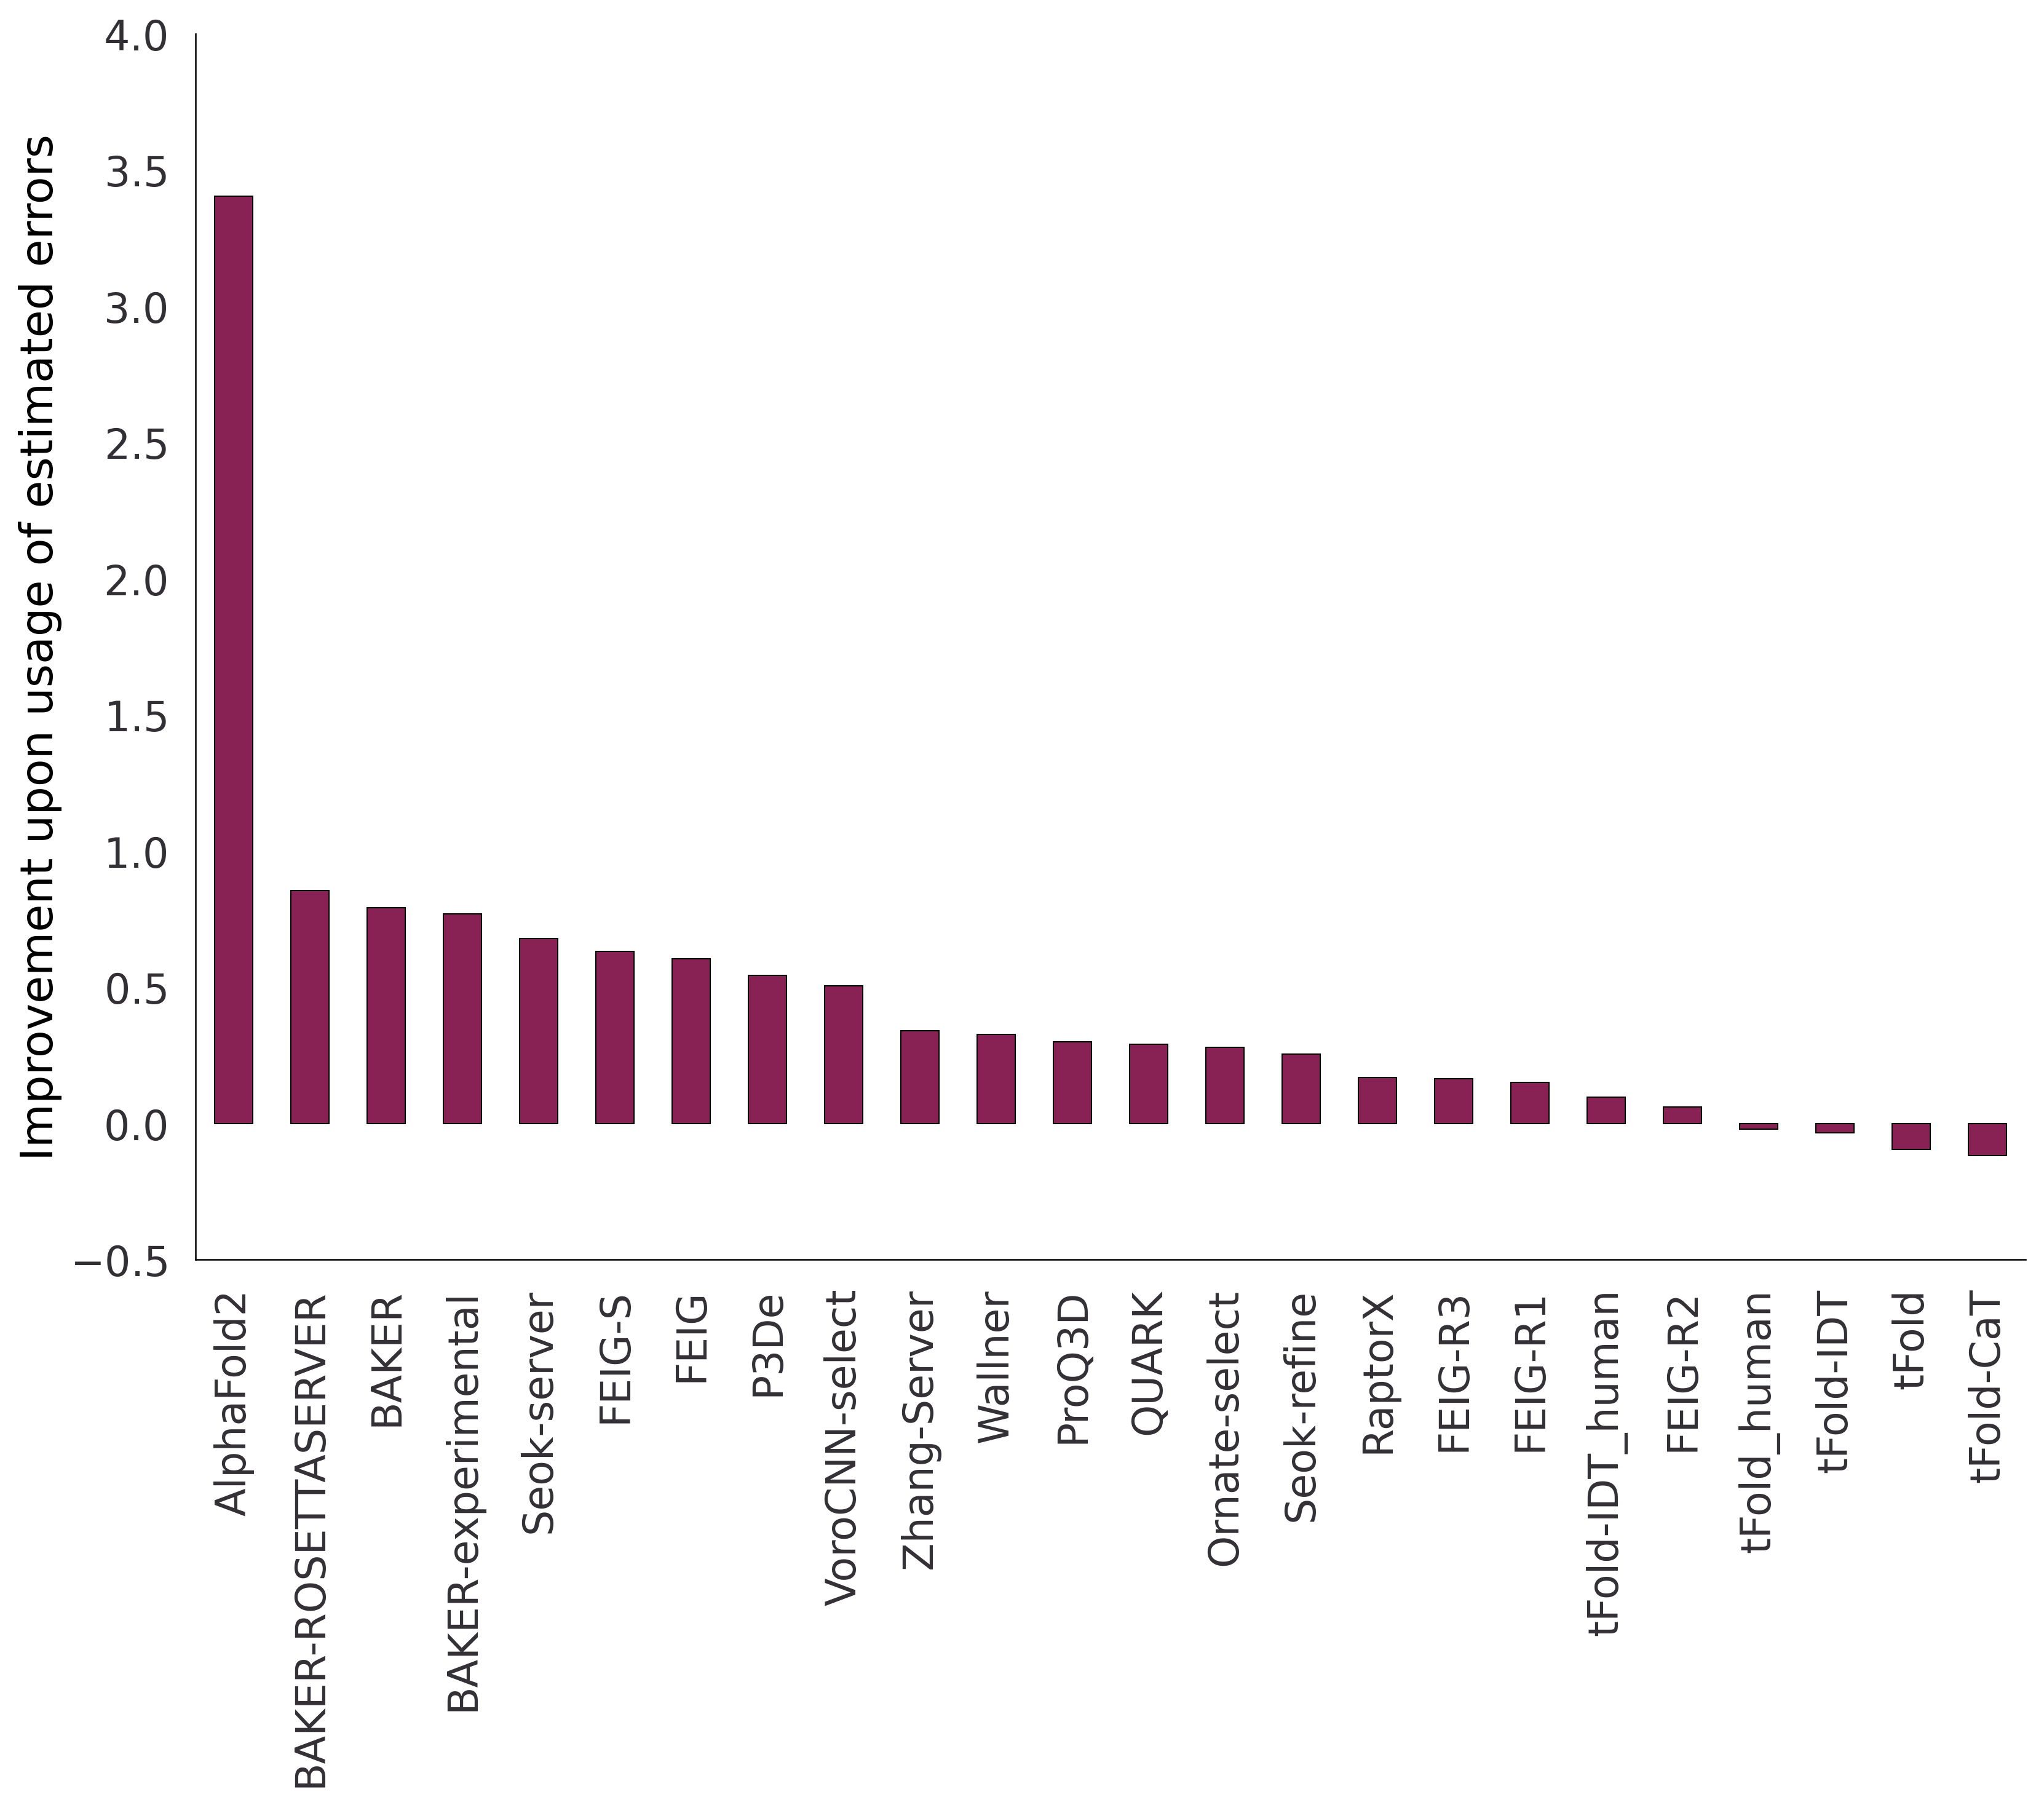

In [ ]:
# Now compare in a plot bar how better they did in terms of comparing raw coordinates to raw coordinates and error estimations

plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'

#display(df_mod1_as_rmsd)
#display(df_mod1_bfac_const)

as_rmsd_by_group = df_mod1_as_rmsd.groupby(['Name_Group'])['reLLG_as_rmsd'].sum()
constant_by_group = df_mod1_bfac_const.groupby(['Name_Group'])['reLLG_bfactor_constant'].sum()
#display(as_rmsd_by_group)
#display(constant_by_group)

merged_df = pd.merge(as_rmsd_by_group,constant_by_group,right_index = True,left_index = True)
display(merged_df)


# Plot with the two bars [it will not work if the dataframe as the new column difference]
#ax = merged_df.plot.bar(rot=0, title="Comparison between raw coordinates and estimated error",figsize=(40,10))
#ax.set_xlabel("Groups")
#ax.set_ylabel("Sum over reLLG")
#plt.xticks(rotation=90)
#ax.figure.savefig("Comparison_between_raw_coordinates_and_estimated_error_prediction.png",figsize=(40,10),bbox_inches = "tight")
#files.download("Comparison_between_raw_coordinates_and_estimated_error_prediction.png") # This will download it
#plt.show()

merged_df['Difference'] = merged_df['reLLG_as_rmsd'] - merged_df['reLLG_bfactor_constant']
#display(merged_df)

# Get the groups corresponding to the best 20 from as rmsd and from the best 20 from bfactor constant
print("Best ones from as_rmsd")
top20rmsd_df = merged_df.nlargest(20,'reLLG_as_rmsd')
top20rmsd = top20rmsd_df.index.values.tolist()
print(top20rmsd)
print("Best ones from bfactor constant")
top20cons_df = merged_df.nlargest(20,'reLLG_bfactor_constant')
top20cons = top20cons_df.index.values.tolist()
print(top20cons)
unique_top = (set(top20rmsd)).union(set(top20cons))
print("Union is ",unique_top)
print("len of union is ",len(unique_top))
unique_list = list(unique_top)
# Filter by this top
merged_df  = merged_df[merged_df.index.isin(unique_list)]


# Plot with the difference
merged_df.sort_values('Difference', ascending=False, inplace=True)
ax = merged_df['Difference'].plot.bar(rot=0,color='#882255')
ax.set_xlabel("")
ax.set_ylabel("Improvement upon usage of estimated errors")
plt.xticks(rotation=90)
#ax.figure.savefig("Comparison_between_raw_coordinates_and_estimated_error_prediction_difference.png",figsize=(40,10),bbox_inches = "tight")
#files.download("Comparison_between_raw_coordinates_and_estimated_error_prediction_difference.png") # This will download it
plt.show()



Correlation below


-0.018584805017834636

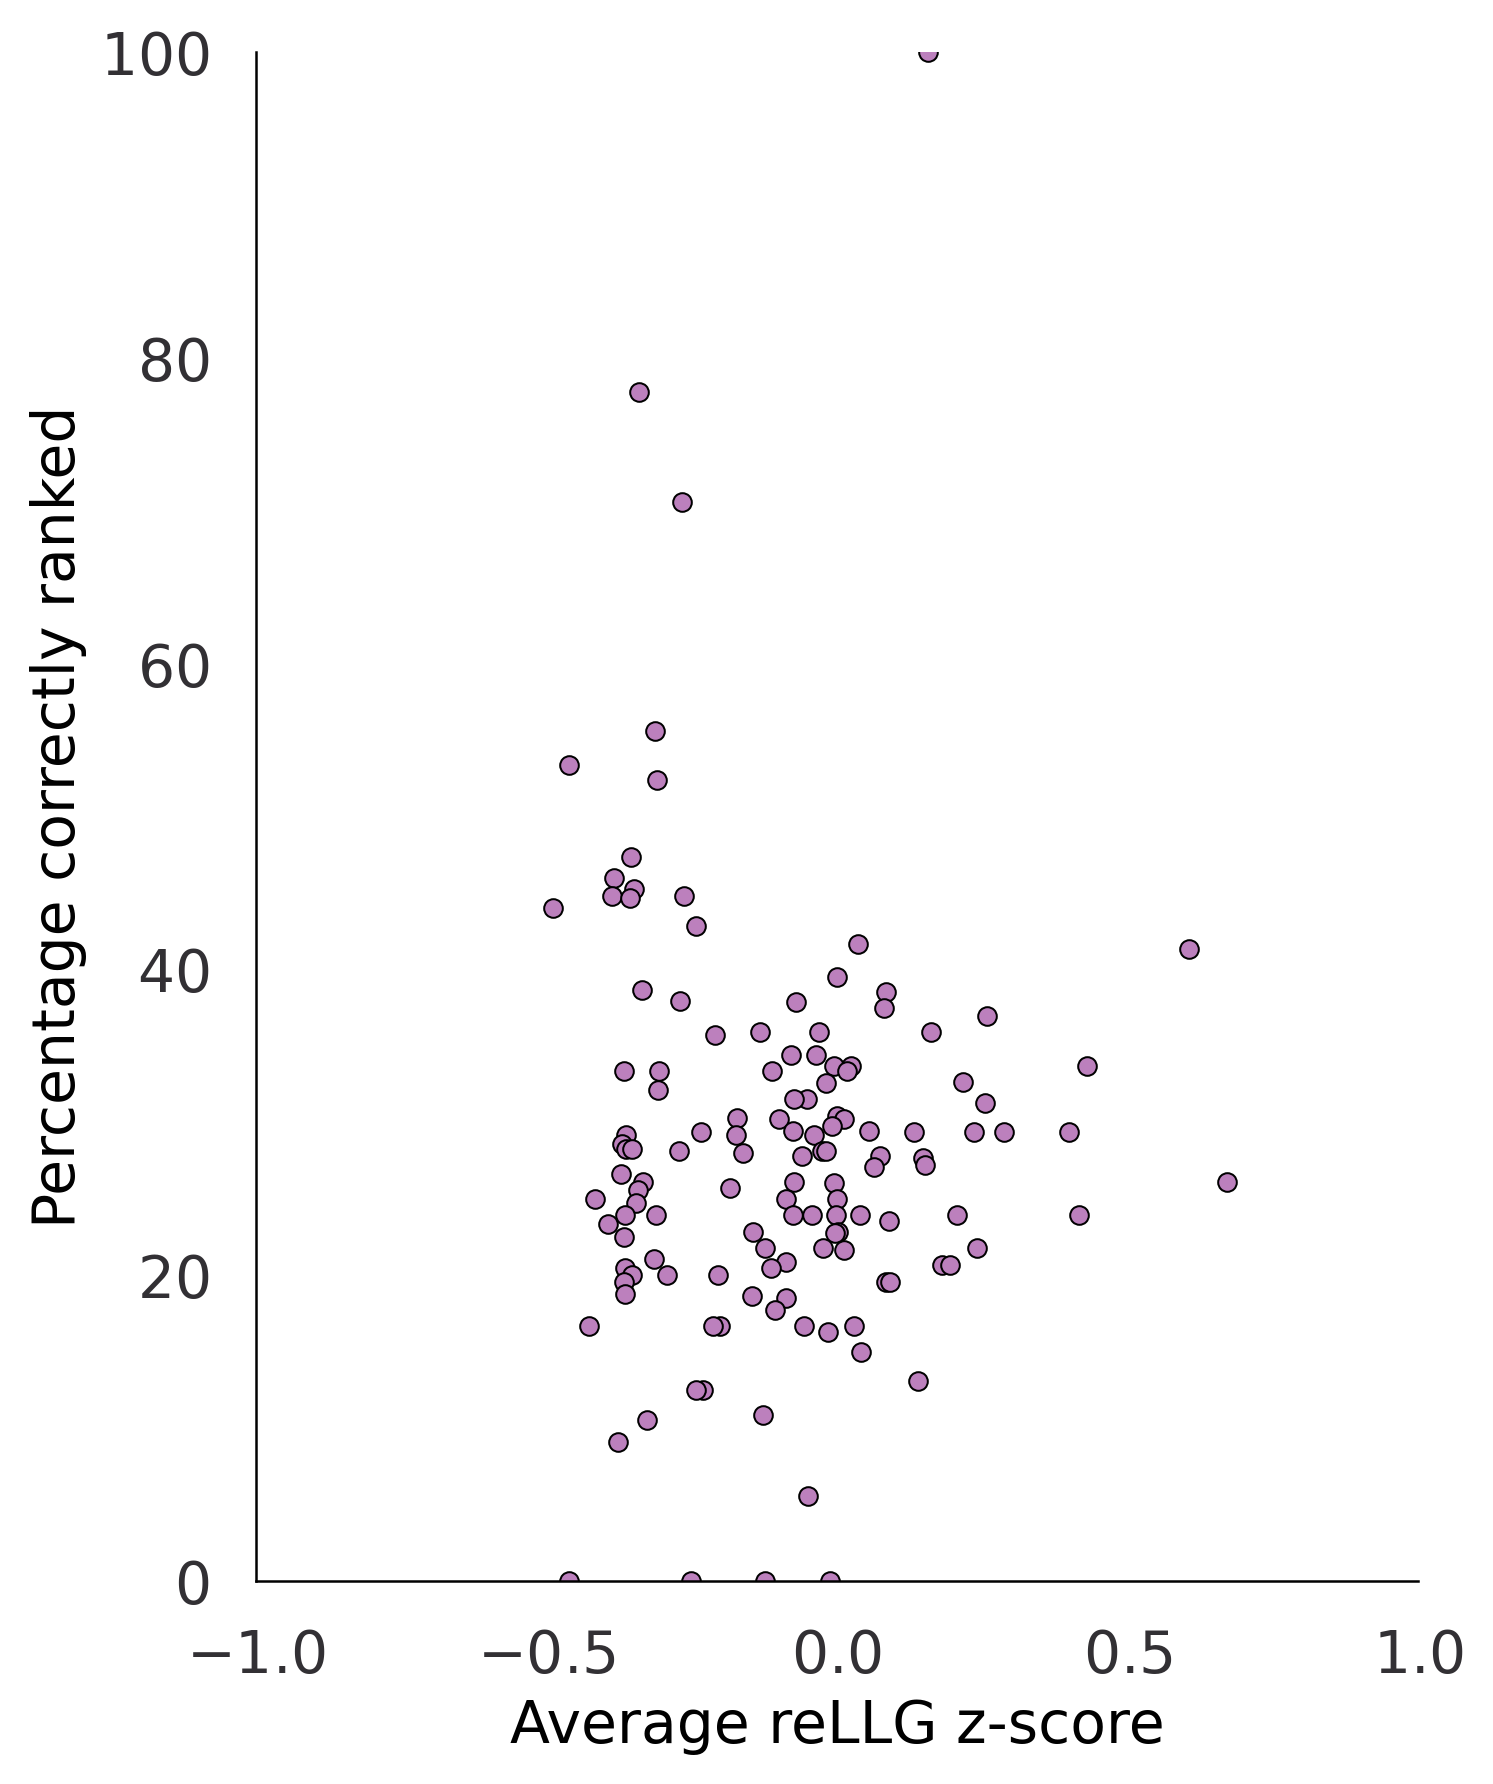

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Percentage,Z-score
Group,,
BAKER,41.304348,0.606264
FEIG-R1,36.956522,0.258998
Bhattacharya,35.869565,-0.031629
Zhang,35.869565,0.162648
FEIG-R2,33.695652,0.430411
Seok-refine,33.695652,0.024834
Wallner,32.608696,0.217603
FEIG-S,31.250000,0.254922
ProQ3D,29.347826,0.131949


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


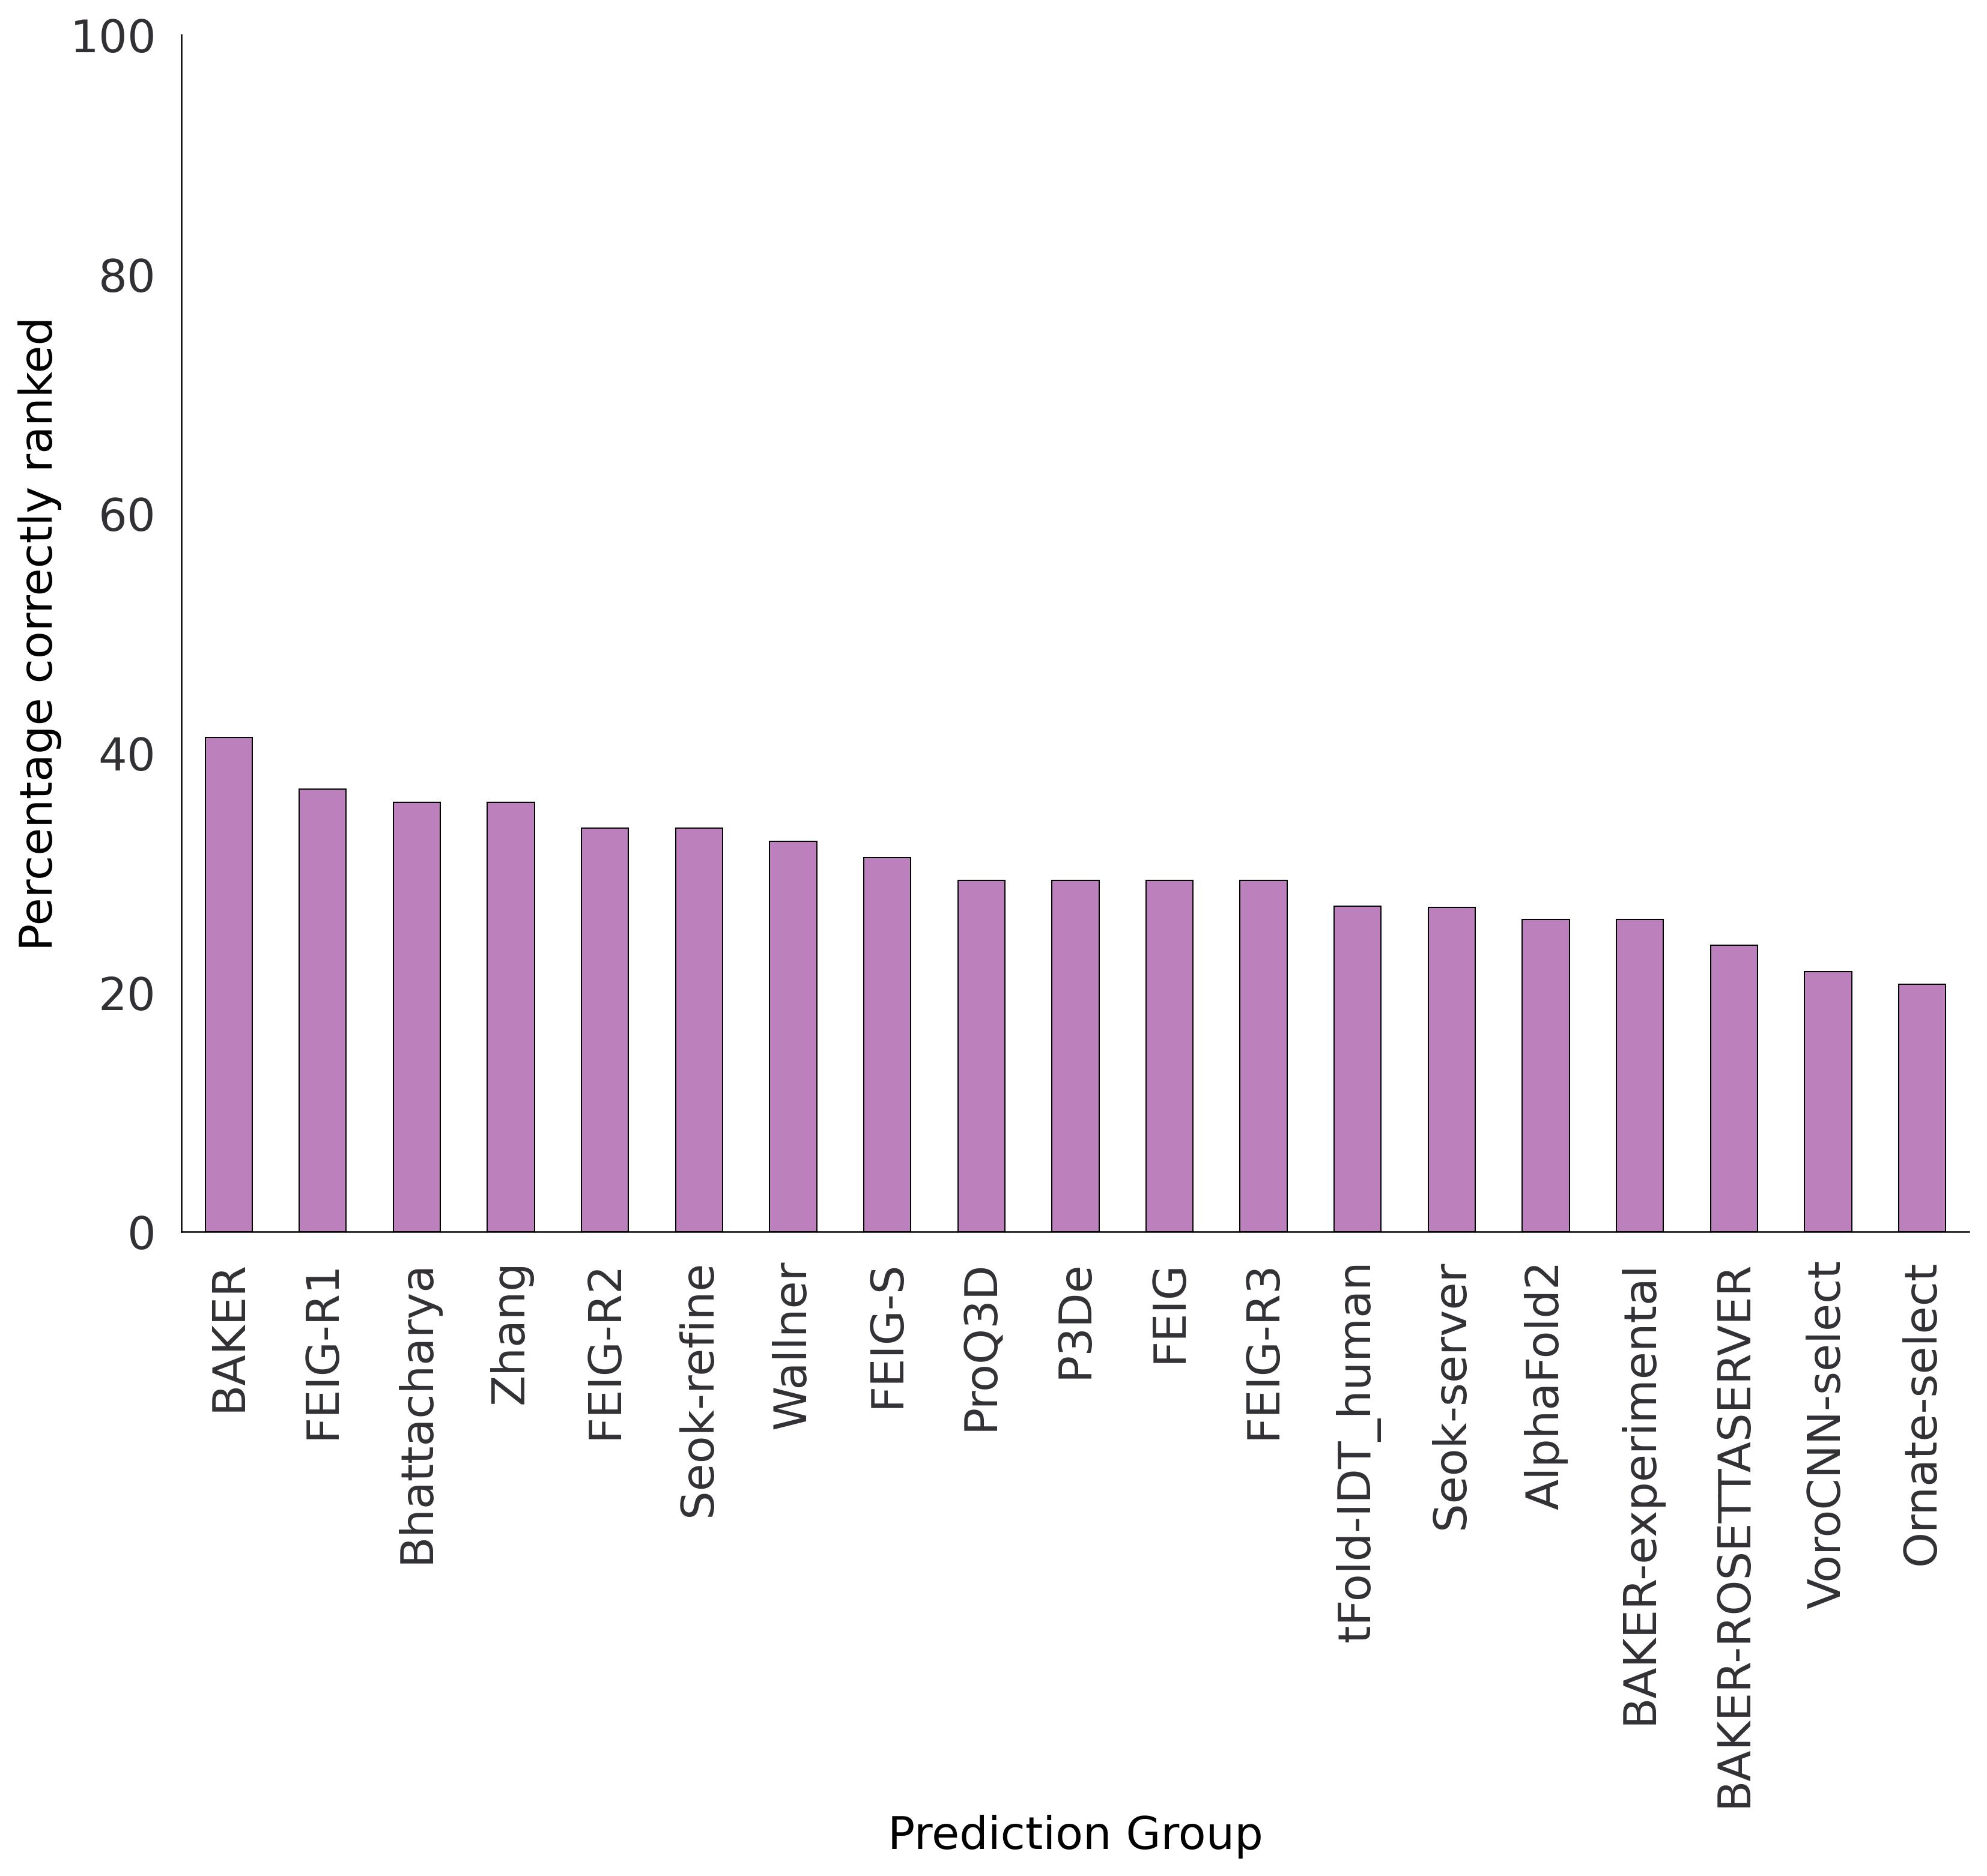

In [ ]:
# Can we see if they got their own ranking right?
# That is, which fraction of their targets were actually right in pointing out model 1 was the best
# For that we need to read the whole table without using only model 1 but using all of them
df_all_targets_and_models = process_all_targets(path_claudia_prediction_tables,treatment='as_rmsd',metric='reLLG',error_check=False,only_first_model=False)
# Include group name and experimental information
df_all_models_rmsd = merge_group_and_experimental_info(df_all_targets_and_models,list_xray,list_cryoem,df_global_methods,df_groups_key)
# This dataframe contains all models
#display(df_all_models_rmsd)
#df_all_models_rmsd

dict_self_rank_correct = {} 
by_groups = df_all_models_rmsd.groupby(['Name_Group'])
dict_colors = {}
dict_average_zscore = {}
for group in by_groups:
  #print("\n\nChecking maximum value for group ",group[0])
  # In each entry we will save in a list 1 per each time their model 1 was actually the best for a given target and 0 when not
  dict_self_rank_correct[group[0]] = []
  # The color will be chosen differently if average value for reLLG is positive or negative
  mean_zscore = group[1]['reLLG_as_rmsd_zscore'].mean()
  dict_average_zscore[group[0]]=mean_zscore
  if mean_zscore < 0:
    dict_colors[group[0]]='lightcoral'
  else:
    dict_colors[group[0]]='palegreen'
  # I can iterate now by each target for this group and see their 5 models
  by_target = group[1].groupby('Target_Evaluation')
  for targeti in by_target:
    #print('\n\n',targeti)
    #print('sherlock len models' ,len(targeti[1]))
    if len(targeti[1])==5:
        # Now get the best score for all their models for that target
        #print('maximum is ',targeti[1]['reLLG_as_rmsd_zscore'].max())
        index_max = targeti[1]['reLLG_as_rmsd_zscore'].idxmax()
        #print(targeti[1].loc[index_max]['Self_rank'])
        if targeti[1].loc[index_max]['Self_rank'] == '1':
            dict_self_rank_correct[group[0]].append(1)
        else:
            dict_self_rank_correct[group[0]].append(0)
    else: 
        # You skip this target because it did not have 5 models
        continue



#print("SHERLOCK check the dict",dict_average_zscore)    

plt.style.use(['/content/drive/MyDrive/DATA_FOR_NOTEBOOKS/mydefplot.mplstyle','seaborn-poster'])
plt.rcParams['font.family'] = 'Arial'

rank_list = []
for keygroup in dict_self_rank_correct.keys():
  #print("SHERLOCK dict_self_rank_correct[keygroup]",dict_self_rank_correct[keygroup])
  #print("SHERLOCK len(dict_self_rank_correct[keygroup])",len(dict_self_rank_correct[keygroup]))
  total = len(dict_self_rank_correct[keygroup])
  if total > 0:
      positives = dict_self_rank_correct[keygroup].count(1) # how many times was the first
      percentage = (positives * 100) / total
      #print('\nGroup ',keygroup,' had ',positives,' out of ',total,' targets with 5 models correctly ranked as first, giving a % of ',percentage)
      rank_list.append((keygroup,percentage))
  else:
    continue

#sorted_rank_list = sorted(rank_list,key=lambda x: x[1], reverse=True)
#for ele in sorted_rank_list:
  #print(ele)

df_for_plot = pd.DataFrame(rank_list, columns =['Group', 'Percentage'])
df_for_plot.sort_values(by=['Percentage'],ascending=False,inplace=True)
#df_for_plot.index = df_for_plot['Group']
df_for_plot.set_index('Group',inplace=True)
#display(df_for_plot)

# Now do a scatter plot
df_zscore = pd.DataFrame.from_dict(dict_average_zscore,orient='index')
df_zscore['Group'] = df_zscore.index
df_zscore.columns=['Z-score','Group']
#display(df_zscore)
merge_for_scatter_full = pd.merge(df_for_plot,df_zscore,on='Group')
print("Correlation below")
display(merge_for_scatter_full['Z-score'].corr(merge_for_scatter_full['Percentage']))
#with pd.option_context('display.max_rows', 500):
#  display(merge_for_scatter_full)
# Testing if removing alphafold makes it more informative
merge_for_scatter = (merge_for_scatter_full.loc[merge_for_scatter_full['Group']!="AlphaFold2"])
#display(merge_for_scatter)
ax = merge_for_scatter.plot.scatter(x="Z-score",y="Percentage",figsize=(5,6.75),s=20,fontsize=14)
ax.set_xlabel("Average reLLG z-score",fontsize=14)
ax.set_ylabel("Percentage correctly ranked",fontsize=14)
plt.ylim(0,100)
plt.show()

#top20byzscore = merge_for_scatter_full.nlargest(20,'Z-score')
#top20byzscore.sort_values(by='Percentage',ascending=False,inplace=True)
#top20byzscore.set_index('Group',inplace=True)
#display(top20byzscore)
# Instead of this we will only plot the results for the top20 that we have already from the previous overall ranking
list_top20 = list(top20.index)
top20filter = merge_for_scatter_full.loc[merge_for_scatter_full['Group'].isin(list_top20)]
top20filter.sort_values(by='Percentage',ascending=False,inplace=True)
top20filter.set_index('Group',inplace=True)
display(top20filter)

# Now also do a bar plot but only with the best top20
ax=top20filter['Percentage'].plot.bar(fontsize=18)
plt.ylim(0,100)
plt.xlabel("Prediction Group",fontsize=18)
plt.ylabel("Percentage correctly ranked",fontsize=18)
plt.show()

In [ ]:
# Now get the best results from alphafold for each target evaluation, will use in a plot in the refinement category
#display(df_all_models_rmsd)
df_alpha = df_all_models_rmsd.loc[df_all_models_rmsd['Name_Group']=='AlphaFold2']
#display(df_alpha)
rank_best_targets_alphafold = df_alpha.groupby(['Target_Evaluation'])['reLLG_as_rmsd'].max()
rank_best_targets_alphafold.sort_values(inplace=True,ascending=False)
print(rank_best_targets_alphafold)
print(len(rank_best_targets_alphafold))
rank_best_targets_alphafold.to_csv(os.path.join(output_dir,'bestalphafold.csv'))

Target_Evaluation
T1078-D1      0.647640
T1068-D1      0.610003
T1087-D1      0.595239
T1052-D2      0.568414
T1089-D1      0.538889
                ...   
T1093-D2      0.016651
T1095-D1      0.008466
T1047s2-D3    0.005574
T1027-D1      0.003506
T1029-D1      0.000531
Name: reLLG_as_rmsd, Length: 92, dtype: float64
92
